In [ ]:
# test with MinMaxScaler and StandardScaler and PolynomialFeatures degree  also tinker with the outliers
# let's create a base line
import pandas as pd
from sklearn.linear_model import Ridge
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder
import numpy as np
import shapely.wkt
import folium
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import holidays
from geopy import distance
import seaborn as sns
import requests
from shapely import wkt
from shapely import Point

import astral
from astral import LocationInfo
from astral.sun import sun
from astral import Observer
import datetime

train_path = "split/split_sample/train.csv"
full_val_path = "split/val.csv"
full_train_path = "split/train.csv"
val_path = "split/split_sample/val.csv"
test_path = "split/split_sample/test.csv"

train_data = pd.read_csv(train_path, engine="pyarrow", dtype_backend="pyarrow")


train_data.tail()

# after loading boro dataframe
# boro_df['the_geom'] = boro_df.the_geom.apply(lambda x : shapely.wkt.loads(x))
boro_neighbor_avg = {}

for neighbor in tf_df.Boro.unique():
    df = tf_df[tf_df.Boro == neighbor]
    boro_neighbor_avg[neighbor] = np.average(df.Vol)
boro_neighbor_avg["unknown"] = np.average(tuple(boro_neighbor_avg.values()))

In [63]:
# we don't need id , vendor_id,store_and_fwd_flag
train_data.drop(["id", "vendor_id", "store_and_fwd_flag"], inplace=True, axis=1)


In [64]:
train_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype                
---  ------             --------------  -----                
 0   pickup_datetime    5000 non-null   timestamp[s][pyarrow]
 1   passenger_count    5000 non-null   int64[pyarrow]       
 2   pickup_longitude   5000 non-null   double[pyarrow]      
 3   pickup_latitude    5000 non-null   double[pyarrow]      
 4   dropoff_longitude  5000 non-null   double[pyarrow]      
 5   dropoff_latitude   5000 non-null   double[pyarrow]      
 6   trip_duration      5000 non-null   int64[pyarrow]       
dtypes: double[pyarrow](4), int64[pyarrow](2), timestamp[s][pyarrow](1)
memory usage: 273.6 KB


In [65]:
# let's check if this data was gathered in what year

train_data["year"] = train_data["pickup_datetime"].apply(lambda x: x.year)
train_data["month"] = train_data["pickup_datetime"].apply(lambda x: x.month)
train_data["day"] = train_data["pickup_datetime"].apply(lambda x: x.day)
train_data["hour"] = train_data["pickup_datetime"].apply(lambda x: x.hour)
train_data["minute"] = train_data["pickup_datetime"].apply(lambda x: x.minute)

In [66]:
# now we don't need the pickup_datetime
train_data.drop("pickup_datetime", axis=1, inplace=True)
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype          
---  ------             --------------  -----          
 0   passenger_count    5000 non-null   int64[pyarrow] 
 1   pickup_longitude   5000 non-null   double[pyarrow]
 2   pickup_latitude    5000 non-null   double[pyarrow]
 3   dropoff_longitude  5000 non-null   double[pyarrow]
 4   dropoff_latitude   5000 non-null   double[pyarrow]
 5   trip_duration      5000 non-null   int64[pyarrow] 
 6   year               5000 non-null   int64          
 7   month              5000 non-null   int64          
 8   day                5000 non-null   int64          
 9   hour               5000 non-null   int64          
 10  minute             5000 non-null   int64          
dtypes: double[pyarrow](4), int64(5), int64[pyarrow](2)
memory usage: 429.8 KB


In [67]:
train_data.dropoff_latitude.head()

0    40.728146
1    40.732971
2      40.7188
3    40.776001
4     40.74313
Name: dropoff_latitude, dtype: double[pyarrow]

In [70]:
# we can make a  base model with this changes
x_train, y_train = (
    train_data.drop("trip_duration", axis=1).to_numpy(),
    np.log1p(train_data.trip_duration.to_numpy().reshape(-1, 1)),
)
x_train.shape, y_train.shape

((5000, 10), (5000, 1))

In [71]:
# now let's apply min_max_scaler over the train_data
scaler = MinMaxScaler()
scaler.fit(x_train)
x_train_trans = scaler.transform(x_train)

In [72]:
base_line_model = Ridge(alpha=1)
base_line_model.fit(x_train_trans, y_train)

Ridge(alpha=1)

In [73]:
# let's check the r score over the train data
from sklearn.metrics import r2_score, root_mean_squared_error

train_r2_score = r2_score(y_true=y_train, y_pred=base_line_model.predict(x_train_trans))
rmse_train = root_mean_squared_error(
    y_true=y_train, y_pred=base_line_model.predict(x_train_trans)
)

print("train r2 score", train_r2_score)
print("rmse train", rmse_train)


train r2 score 0.060480519080876594
rmse train 0.7765768361285956


In [74]:
# we need to check the performance ove the val test


def load_data_into_df(path):
    data = pd.read_csv(path, dtype_backend="pyarrow", engine="pyarrow")

    return data


def add_features(data: pd.DataFrame):
    # data["year"] = data["pickup_datetime"].apply(lambda x: x.year) useless for now
    data["month"] = data["pickup_datetime"].apply(lambda x: x.month)
    data["day"] = data["pickup_datetime"].apply(lambda x: x.day)
    data["hour"] = data["pickup_datetime"].apply(lambda x: x.hour)
    data["minute"] = data["pickup_datetime"].apply(lambda x: x.minute)


def drop_features(data, features: pd.DataFrame):
    data.drop(features, axis=1, inplace=True)


def split_data(data):
    x_train, y_train = (
        train_data.drop("trip_duration", axis=1).to_numpy(),
        np.log1p(train_data.trip_duration.to_numpy().reshape(-1, 1)),
    )
    return x_train, y_train


def scale_data(data, scaler=scaler):
    return scaler.transform(data)


val_data = load_data_into_df(val_path)
add_features(val_data)
drop_features(val_data, ["id", "vendor_id", "store_and_fwd_flag", "pickup_datetime"])
x_val, y_val = split_data(val_data)
x_val_trans = scale_data(x_val)

In [76]:
val_r2_score = r2_score(y_true=y_val, y_pred=base_line_model.predict(x_val_trans))
rmse_val = root_mean_squared_error(
    y_true=y_val, y_pred=base_line_model.predict(x_val_trans)
)
print("r2 score val ", val_r2_score, "rmse val", rmse_val)


r2 score val  0.060480519080876594 rmse val 0.7765768361285956


# feature Engineering 
the goal is to come with with some feature to enhance this shitty performance 
initial  ideas
- distance between the pick up and drop off location  we have corr = 0.6215306568867298
- distance using geopy module gave use corr = 0.62140824009962
- vertical distance , different between 2 lat.  v distance corr 0.5600230488978144
- horizontal distance   difference between 2 long. h distance corr  0.5188671261592941
- at which time of the day it was picked ! (interesting) i got corr = 0.019037168719444414 which is pretty low but i think this is because there is no linear relationship between it and the output we will see .
- i will try to add time estimate form open source data to help the model 
-**using some polynomial features to help the model!**


In [77]:
def getDistanceFromLatLonInKm(lat1, lon1, lat2, lon2):
    R = 6371  # Radius of the earth in km
    dLat = deg2rad(lat2 - lat1)  # deg2rad below
    dLon = deg2rad(lon2 - lon1)
    a = np.sin(dLat / 2) * np.sin(dLat / 2) + np.cos(deg2rad(lat1)) * np.cos(
        deg2rad(lat2)
    ) * np.sin(dLon / 2) * np.sin(dLon / 2)

    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    d = R * c  # Distance in km
    return d


def deg2rad(deg):
    return deg * (np.pi / 180)


In [78]:
train_df = load_data_into_df(train_path)
train_df.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'passenger_count',
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'store_and_fwd_flag', 'trip_duration'],
      dtype='object')

In [79]:
distance = getDistanceFromLatLonInKm(
    train_df["pickup_latitude"],
    train_df["pickup_longitude"],
    train_df["dropoff_latitude"],
    train_df["dropoff_longitude"],
)

<Axes: >

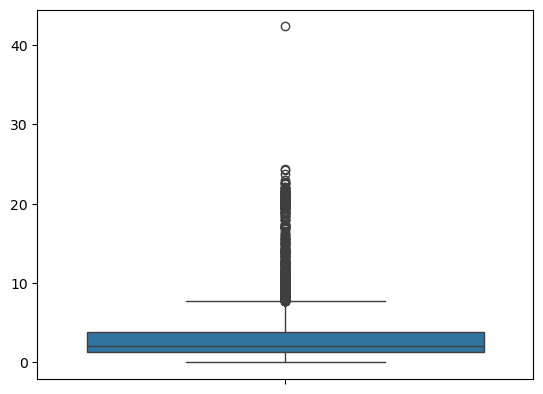

In [80]:
import seaborn as sns

sns.boxplot(distance)

In [81]:
# let's check the correlation between this feature and the y
distance = distance.to_numpy().reshape(-1, 1)


In [82]:
epsilon = 0
corr_matrix = np.corrcoef(distance + epsilon, y_train + epsilon, rowvar=False)
corr_matrix[0, 1]  #

0.6215306568867298

In [83]:
train_data["distance"] = distance

In [84]:
train_data.pickup_latitude.head()

0    40.751068
1    40.745071
2     40.72858
3     40.75985
4    40.758221
Name: pickup_latitude, dtype: double[pyarrow]

In [85]:
from geopy import distance


# let's compare the distance to what we calculated
def geo_dist(row):
    return distance.distance(
        (row["pickup_latitude"], row["pickup_longitude"]),
        (row["dropoff_latitude"], row["dropoff_longitude"]),
    ).km


geo_dist = train_df.apply(geo_dist, axis=1)

In [86]:
corr_matrix = np.corrcoef(geo_dist + epsilon, y_train + epsilon, rowvar=False)
corr_matrix[0, 1]  #

0.62140824009962

In [87]:
train_data["geo_distance"] = geo_dist

In [88]:
train_data.columns

Index(['passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'trip_duration', 'year',
       'month', 'day', 'hour', 'minute', 'distance', 'geo_distance'],
      dtype='object')

In [89]:
def h_distance(row):
    return np.abs(row["pickup_longitude"] - row["dropoff_longitude"])


def v_distance(row):
    return np.abs(row["pickup_latitude"] - row["dropoff_latitude"])


train_data["h_distance"] = h_distance

h_distance = train_df.apply(h_distance, axis=1)
v_distance = train_df.apply(v_distance, axis=1)
train_data["h_distance"] = h_distance
train_data["v_distance"] = v_distance

In [90]:
h_dist_corr = np.corrcoef(h_distance + epsilon, y_train + epsilon, rowvar=False)
v_dist_corr = np.corrcoef(v_distance + epsilon, y_train + epsilon, rowvar=False)

print("h distance corr ", h_dist_corr[0, 1], "v distance corr", v_dist_corr[0, 1])

h distance corr  0.5188671261592941 v distance corr 0.5600230488978144


In [91]:
def rush_hour(row):
    # morning or evening rush hour
    return (
        1
        if 6 <= row["pickup_datetime"].hour <= 10
        or 13 <= row["pickup_datetime"].hour <= 20
        else 0
    )


In [92]:
rush_hours = train_df.apply(rush_hour, axis=1)


In [93]:
rush_hours_corr = np.corrcoef(rush_hours + epsilon, y_train + epsilon, rowvar=False)
rush_hours_corr[0, 1]


0.019037168719444414

In [94]:
train_data["rush_hour"] = rush_hours

In [95]:
train_df.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'passenger_count',
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'store_and_fwd_flag', 'trip_duration'],
      dtype='object')

In [96]:
rush_hours.value_counts()

1    3092
0    1908
Name: count, dtype: int64

In [97]:
train_data.columns

Index(['passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'trip_duration', 'year',
       'month', 'day', 'hour', 'minute', 'distance', 'geo_distance',
       'h_distance', 'v_distance', 'rush_hour'],
      dtype='object')

In [98]:
train_data["pickup_longitude"][0], train_data["pickup_latitude"][0]

(-73.99064636230467, 40.751068115234375)

In [99]:
train_data.columns

Index(['passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'trip_duration', 'year',
       'month', 'day', 'hour', 'minute', 'distance', 'geo_distance',
       'h_distance', 'v_distance', 'rush_hour'],
      dtype='object')

In [100]:
train_data.year.unique()

array([2016])

In [ ]:
def load_data_into_df(path):
    data = pd.read_csv(path, dtype_backend="pyarrow", engine="pyarrow")

    return data


def add_features(data: pd.DataFrame):
    # data["year"] = data["pickup_datetime"].apply(lambda x: x.year) useless for now
    data["month"] = data["pickup_datetime"].apply(lambda x: x.month)
    data["day"] = data["pickup_datetime"].apply(lambda x: x.day)
    data["hour"] = data["pickup_datetime"].apply(lambda x: x.hour)
    data["minute"] = data["pickup_datetime"].apply(lambda x: x.minute)
    data["week"] = data["pickup_datetime"].apply(lambda x: x.week)
    data["week_day"] = data["pickup_datetime"].apply(lambda x: x.day_of_week)
    data["week_of_year"] = data["pickup_datetime"].apply(lambda x: x.weekofyear)
    data["quarter"] = data["pickup_datetime"].apply(lambda x: x.quarter)
    data["weekend_status"] = data["pickup_datetime"].apply(
        lambda x: 1 if x.day_name() in ("Saturday", "Sunday") else 0
    )
    # holiday or not
    us_holidays = holidays.US()

    data["is_holiday"] = data["pickup_datetime"].apply(
        lambda x: 1 if x.date() in us_holidays else 0
    )

    # cyclic features
    data["hour_sin"] = np.sin(2 * np.pi * data["hour"] / 24)
    data["hour_cos"] = np.cos(2 * np.pi * data["hour"] / 24)
    data["minute_sin"] = np.sin(2 * np.pi * data["minute"] / 60)
    data["minute_cos"] = np.cos(2 * np.pi * data["minute"] / 60)
    data["week_sin"] = np.sin(2 * np.pi * data["week"] / 4)
    data["week_cos"] = np.cos(2 * np.pi * data["week"] / 4)
    data["week_of_year_sin"] = np.sin(2 * np.pi * data["week_of_year"] / 48)
    data["week_of_year_cos"] = np.cos(2 * np.pi * data["week_of_year"] / 48)
    # haversine distance which is the same as geo_distance
    # def getDistanceFromLatLonInKm(lat1, lon1, lat2, lon2):
    #     R = 6371  # Radius of the earth in km
    #     dLat = deg2rad(lat2 - lat1)  # deg2rad below
    #     dLon = deg2rad(lon2 - lon1)
    #     a = np.sin(dLat / 2) * np.sin(dLat / 2) + np.cos(deg2rad(lat1)) * np.cos(
    #         deg2rad(lat2)
    #     ) * np.sin(dLon / 2) * np.sin(dLon / 2)

    #     c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    #     d = R * c  # Distance in km
    #     return d

    # def deg2rad(deg):
    #     return deg * (np.pi / 180)

    # data["haversine_distance"] = getDistanceFromLatLonInKm(
    #     data["pickup_latitude"],
    #     data["pickup_longitude"],
    #     data["dropoff_latitude"],
    #     data["dropoff_longitude"],
    # )
    from geopy import distance

    def geo_dist(row):
        return distance.distance(
            (row["pickup_latitude"], row["pickup_longitude"]),
            (row["dropoff_latitude"], row["dropoff_longitude"]),
        ).km

    data["geo_dist"] = data.apply(geo_dist, axis=1)
    # passenger per km
    data["passenger_per_geodist"] = data["passenger_count"] / (data["geo_dist"] + 1e-3)

    # vertical and horizontal distance
    def h_distance(row):
        # 111.3 is the distance between two longitude lines
        return np.abs(row["pickup_longitude"] - row["dropoff_longitude"]) * 111.3

    def v_distance(row):
        # 111.3 is the distance between two latitude lines
        return np.abs(row["pickup_latitude"] - row["dropoff_latitude"]) * 111

    data["h_distance"] = data.apply(h_distance, axis=1)
    data["v_distance"] = data.apply(v_distance, axis=1)

    # def euclidean_distance(row): # hur the model performance
    #     return np.sqrt(
    #         np.square(row["dropoff_latitude"] - row["pickup_longitude"])
    #         + np.square(row["pickup_longitude"] - row["dropoff_longitude"]),
    #     )

    # euclidean_dist = train_data.apply(euclidean_distance, axis=1)
    # data['euclidean_dist']=euclidean_dist

    # rush hours
    def is_rush_hour(row):
        return (
            1
            if 6 <= row["pickup_datetime"].hour <= 10
            or 13 <= row["pickup_datetime"].hour <= 20
            else 0
        )

    data["is_rush_hour"] = data.apply(is_rush_hour, axis=1)

    # osrm time estimate for the trip duration
    import requests

    def osrm_distance_time_estimate(row: pd.DataFrame):
        start = f"{row['pickup_longitude']},{row['pickup_latitude']}"
        end = f"{row['dropoff_longitude']},{row['dropoff_latitude']}"

        url = f"http://localhost:5000/route/v1/driving/{start};{end}?overview=false"
        response = requests.get(url)
        duration = None
        distance = None
        # Check if the request was successful
        if response.status_code == 200:
            data = response.json()
            routes = data.get("routes", [])
            if routes:
                route = routes[0]
                distance = route.get("distance", 0) / 1000  # in km
                duration = route.get("duration", 0)  # in seconds
        return (
            distance if distance else 3.2345,
            duration if duration else 848.857,
        )  # mean for trip duration in training data

    distance_time_estimate = data.apply(osrm_distance_time_estimate, axis=1)
    data["osrm_distance"], data["osrm_time"] = (
        distance_time_estimate.apply(lambda x: x[0]),
        distance_time_estimate.apply(lambda x: x[1]),
    )

    data["osrm_implied_speed"] = data["osrm_distance"] / (data["osrm_time"] + 1e-4)
    data['geo_implied_speed']= data["geo_dist"] / (data["osrm_time"] + 1e-4)
    data["osrm_dist/geo_dist"] = data["osrm_distance"] / (data["geo_dist"] + 1e-4)
    data["passenger_per_osrm_dist"] = data["passenger_count"] / (data["osrm_distance"] + 1e-3)

    def boro(row, col="pickup"):
        from shapely import Point

        if col == "pickup":
            point = Point(row.pickup_longitude, row.pickup_latitude)
        else:
            point = Point(row.dropoff_longitude, row.dropoff_latitude)

        check = boro_df["the_geom"].apply(lambda x: point.within(x))
        # print(type(boro_df[check]["BoroName"].values))
        # return np.array2string( boro_df[check]["BoroName"].values)
        neighbor = "".join(map(str, boro_df[check]["BoroName"].values))
        return neighbor if neighbor else "unknown"

    data["pickup_boro"] = data[["pickup_longitude", "pickup_latitude"]].apply(
        boro, axis=1
    )
    # )
    data["dropoff_boro"] = data[["dropoff_longitude", "dropoff_latitude"]].apply(
        boro, args=("dropoff",), axis=1
    )

    def volume(row, col="pickup_boro"):
        # can be enhanced to get the exact volume by the hour if available
        return boro_neighbor_avg[row[col]]

    data["traffic_volume_pickup"] = data.apply(volume, args=("pickup_boro",), axis=1)
    data["traffic_volume_dropoff"] = data.apply(volume, args=("dropoff_boro",), axis=1)

    # weather data
    def add_weather_data(row, col="maximum temperature"):
        day = row["day"]
        month = row["month"]
        weather_row = weather_df.loc[f"{int(day)}-{int(month)}-2016"]
        return weather_row[col]

    data["max_temp"] = data.apply(
        add_weather_data, args=("maximum temperature",), axis=1
    )
    data["min_temp"] = data.apply(
        add_weather_data, args=("minimum temperature",), axis=1
    )
    data["avg_temp"] = data.apply(
        add_weather_data, args=("average temperature",), axis=1
    )
    data["precipitation"] = data.apply(
        add_weather_data, args=("precipitation",), axis=1
    )
    data["snow fall"] = data.apply(add_weather_data, args=("snow fall",), axis=1)
    data["snow depth"] = data.apply(add_weather_data, args=("snow depth",), axis=1)

    def daylight_minutes(row):
        # Extract latitude and longitude from the row
        latitude = row["pickup_latitude"]
        longitude = row["pickup_longitude"]

        # Create an Observer object
        observer = Observer(latitude=latitude, longitude=longitude)

        # date = datetime.date(2016, row['month'], row['day'])
        date = row["pickup_datetime"]
        s = sun(observer, date=date, tzinfo="US/Eastern")

        # Calculate daylight duration
        daylight_duration = s["sunset"] - s["sunrise"]

        # Convert duration to total minutes
        total_minutes = daylight_duration.total_seconds() / 60
        return total_minutes

    data["daylight_minutes"] = data.apply(daylight_minutes, axis=1)


def one_hot_encode(data):
    categories = [
        ["Brooklyn", "Staten Island", "Manhattan", "Bronx", "Queens", "unknown"]
    ]
    encoder = OneHotEncoder(sparse_output=False, categories=categories, dtype=int)
    pickup = encoder.fit_transform(data["pickup_boro"].to_numpy().reshape(-1, 1))
    pick_up_categories = [category + "pickup" for category in categories[0]]
    pickup_df = pd.DataFrame(pickup, columns=pick_up_categories)
    # print(pickup_df.head())

    # drop off
    dropoff = encoder.transform(data["dropoff_boro"].to_numpy().reshape(-1, 1))
    dropoff_categories = [category + "dropoff" for category in categories[0]]
    dropoff_df = pd.DataFrame(dropoff, columns=dropoff_categories)
    # print("drop off ")
    # print(dropoff_df.head())

    return pd.concat([data, pickup_df, dropoff_df], axis=1)


def drop_features(data, features: pd.DataFrame):
    data.drop(features, axis=1, inplace=True)


def split_data(data):
    x_train, y_train = (
        data.drop("trip_duration", axis=1).to_numpy(),
        np.log1p(data.trip_duration.to_numpy().reshape(-1, 1)),
    )
    return x_train, y_train


def filter_outliers(data):
    first_stage = data[data.geo_dist <= data["geo_dist"].quantile(0.99)]
    second_stage = first_stage[first_stage.geo_dist >= data["geo_dist"].quantile(0.1)]
    return second_stage


def scale_data(data, scaler):
    if scaler is None:
        # scaler = StandardScaler()
        scaler =MinMaxScaler()
        scaler.fit(data)

    return scaler.transform(data), scaler


# def poly_features(data, osrm_time, osrm_distance, degree=3):
def poly_features(data, degree=2):
    # ploy = PolynomialFeatures(degree=degree,interaction_only=True)
    ploy = PolynomialFeatures(degree=degree, interaction_only=False)
    transformed = ploy.fit_transform(data)
    # return np.hstack((transformed , osrm_time.to_numpy().reshape(-1,1) , osrm_distance.to_numpy().reshape(-1,1)))
    return transformed


train_data = load_data_into_df(full_train_path)

add_features(train_data)
train_data = one_hot_encode(train_data)
drop_features(
    train_data,
    [
        "id",
        "vendor_id",
        "store_and_fwd_flag",
        "pickup_datetime",
        "pickup_boro",
        "dropoff_boro",
    ],
)

outlier_free_train = filter_outliers(train_data)

# osrm_time , osrm_distance = outlier_free_train['osrm_time'], outlier_free_train['osrm_distance']
# dropping osrm_time and osrm_distance before poly features
# outlier_free_train.drop(['osrm_time', 'osrm_distance'], inplace =True , axis =1)

x_train, y_train = split_data(outlier_free_train)

# x_train = poly_features(x_train,osrm_time, osrm_distance)
x_train = poly_features(x_train)
x_train_trans, scaler = scale_data(x_train, None)


In [ ]:
boro_neighbor_avg.keys()

dict_keys(['Queens', 'Manhattan', 'Brooklyn', 'Staten Island', 'Bronx', 'unknown'])

In [145]:
# let's check the r score over the train data
from sklearn.metrics import r2_score, root_mean_squared_error

v1_model = Ridge(alpha=1)
v1_model.fit(x_train_trans, y_train)
train_r2_score = r2_score(y_true=y_train, y_pred=v1_model.predict(x_train_trans))
rmse_train = root_mean_squared_error(
    y_true=y_train, y_pred=v1_model.predict(x_train_trans)
)

print("train r2 score", train_r2_score)
print("rmse train", rmse_train)


train r2 score 0.6951737737692256
rmse train 0.3721347404670376


In [ ]:
print("evaluating v1 model over val data we get ")
val_data = load_data_into_df(full_val_path)
add_features(val_data)
val_data = one_hot_encode(val_data)
drop_features(
    val_data,
    [
        "id",
        "vendor_id",
        "store_and_fwd_flag",
        "pickup_datetime",
        "pickup_boro",
        "dropoff_boro",
    ],
)

clean_data = filter_outliers(val_data)

# osrm_time, osrm_distance = clean_data["osrm_time"], clean_data["osrm_distance"]

# dropping osrm_time and osrm_distance before poly features
# clean_data.drop(["osrm_time", "osrm_distance"], inplace=True, axis=1)

x_val, y_val = split_data(clean_data)

x_val = poly_features(x_val)  # osrm_time, osrm_distance

x_val_trans, _ = scale_data(x_val, scaler)
val_r2_score = r2_score(y_true=y_val, y_pred=v1_model.predict(x_val_trans))
rmse_val = root_mean_squared_error(y_true=y_val, y_pred=v1_model.predict(x_val_trans))

print("val r2 score", val_r2_score)
print("rmse val", rmse_val)


evaluating v1 model over val data we get 
val r2 score 0.6926658833436172
rmse val 0.37410464653984377


In [144]:
x_train.shape

(890000, 1653)

In [ ]:
sorted(train_data.columns)

['day',
 'dropoff_latitude',
 'dropoff_longitude',
 'geo_dist',
 'h_distance',
 'hour',
 'hour_cos',
 'hour_sin',
 'implied_osrm_speed',
 'is_holiday',
 'is_rush_hour',
 'minute',
 'minute_cos',
 'minute_sin',
 'month',
 'osrm_dist/geo_dist',
 'osrm_distance',
 'osrm_time',
 'passenger_count',
 'passenger_per_km',
 'pickup_latitude',
 'pickup_longitude',
 'quarter',
 'trip_duration',
 'v_distance',
 'week',
 'week_cos',
 'week_day',
 'week_of_year',
 'week_of_year_cos',
 'week_of_year_sin',
 'week_sin',
 'weekend_status']

In [ ]:
train_data.columns

Index(['passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'trip_duration', 'month',
       'day', 'hour', 'minute', 'week', 'week_day', 'week_of_year', 'quarter',
       'weekend_status', 'is_holiday', 'hour_sin', 'hour_cos', 'minute_sin',
       'minute_cos', 'week_sin', 'week_cos', 'week_of_year_sin',
       'week_of_year_cos', 'geo_dist', 'passenger_per_km', 'h_distance',
       'v_distance', 'is_rush_hour', 'osrm_distance', 'osrm_time',
       'implied_osrm_speed', 'osrm_dist/geo_dist'],
      dtype='object')

In [ ]:
# sns.set_theme(style="ticks")
# train_data['trip_duration']=train_data['trip_duration'].to_numpy().reshape(-1,1)

# sns.pairplot(train_data,hue = 'trip_duration' )


In [ ]:
train_data.describe()

,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,month,day,hour,minute,...,week_of_year_cos,geo_dist,passenger_per_km,h_distance,v_distance,is_rush_hour,osrm_distance,osrm_time,implied_osrm_speed,osrm_dist/geo_dist
count,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.000000,5000.000000,5000.000000,5000.000000,...,5000.000000,5000.000000,5000.0,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,1.6544,-73.973659,40.75153,-73.972305,40.752438,969.6082,3.492600,15.332400,13.521200,29.598600,...,-0.075969,3.414660,6.490743,2.676809,2.377144,0.618400,4.573105,458.149262,462.722467,117.849339
std,1.29325,0.057585,0.042378,0.056861,0.045901,3616.929016,1.681104,8.674178,6.419174,17.244343,...,0.714450,3.881500,84.138782,4.127643,2.668217,0.485828,5.312931,373.996718,379.105196,1937.314376
min,1.0,-74.177292,40.619514,-74.183403,40.575306,2.0,1.000000,1.000000,0.000000,0.000000,...,-1.000000,0.000000,0.023609,0.000000,0.000000,0.000000,0.000100,0.200000,0.200900,0.085883
25%,1.0,-73.991638,40.737639,-73.991266,40.735735,392.0,2.000000,8.000000,9.000000,14.750000,...,-0.793353,1.244505,0.321762,0.698639,0.767999,0.000000,1.660825,209.600000,211.204375,1.187223
50%,1.0,-73.981895,40.754238,-73.979771,40.754862,656.0,3.000000,15.000000,14.000000,30.000000,...,-0.130526,2.100058,0.611795,1.388363,1.524353,1.000000,2.770500,342.250000,344.738750,1.320267
75%,2.0,-73.967855,40.768205,-73.96224,40.770319,1066.0,5.000000,23.000000,19.000000,45.000000,...,0.608761,3.833198,1.160015,2.660392,2.952270,1.000000,5.006800,574.425000,579.283575,1.437973
max,6.0,-70.851616,43.017578,-70.851616,43.017578,86329.0,6.000000,31.000000,23.000000,59.000000,...,0.991445,42.355476,3000.0,32.907172,34.245861,1.000000,63.861800,4125.000000,4188.861900,32345.000000


In [ ]:
train_data.columns

Index(['passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'trip_duration', 'month',
       'day', 'hour', 'minute', 'week', 'week_day', 'week_of_year', 'quarter',
       'weekend_status', 'is_holiday', 'hour_sin', 'hour_cos', 'minute_sin',
       'minute_cos', 'week_sin', 'week_cos', 'week_of_year_sin',
       'week_of_year_cos', 'geo_dist', 'passenger_per_km', 'h_distance',
       'v_distance', 'is_rush_hour', 'osrm_distance', 'osrm_time',
       'implied_osrm_speed', 'osrm_dist/geo_dist'],
      dtype='object')

In [ ]:
def euclidean_distance(row):
    return np.sqrt(
        np.square(row["dropoff_latitude"] - row["pickup_longitude"])
        + np.square(row["pickup_longitude"] - row["dropoff_longitude"]),
    )


euclidean_dist = train_data.apply(euclidean_distance, axis=1)


In [ ]:
# euc_distance_corr = np.corrcoef(
#     euclidean_dist + epsilon, y_train + epsilon, rowvar=False
# )
# rush_hours_corr[0, 1]

In [ ]:
train_data_trip_dropped = outlier_free_train.drop("trip_duration", axis=1)
log_y_train = pd.DataFrame(np.log1p(y_train), columns=["trip_duration"])
# concatenate y_train , and x_train for detecting outliers
train_concat = pd.concat([train_data_trip_dropped, log_y_train], axis=1)
train_concat.columns
# sns.boxenplot(train_df , x='geo_dist' , y = 'tip_duration')

Index(['passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'month', 'day', 'hour',
       'minute', 'week', 'week_day', 'week_of_year', 'quarter',
       'weekend_status', 'is_holiday', 'hour_sin', 'hour_cos', 'minute_sin',
       'minute_cos', 'week_sin', 'week_cos', 'week_of_year_sin',
       'week_of_year_cos', 'geo_dist', 'passenger_per_km', 'h_distance',
       'v_distance', 'is_rush_hour', 'osrm_distance', 'osrm_time',
       'implied_osrm_speed', 'osrm_dist/geo_dist', 'tv_pickup', 'tv_dropoff',
       'Brooklynpickup', 'Staten Islandpickup', 'Manhattanpickup',
       'Bronxpickup', 'Queenspickup', 'unknownpickup', 'Brooklyndropoff',
       'Staten Islanddropoff', 'Manhattandropoff', 'Bronxdropoff',
       'Queensdropoff', 'unknowndropoff', 'trip_duration'],
      dtype='object')

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32],
 [Text(0, 0, 'passenger_count'),
  Text(1, 0, 'pickup_longitude'),
  Text(2, 0, 'pickup_latitude'),
  Text(3, 0, 'dropoff_longitude'),
  Text(4, 0, 'dropoff_latitude'),
  Text(5, 0, 'month'),
  Text(6, 0, 'day'),
  Text(7, 0, 'hour'),
  Text(8, 0, 'minute'),
  Text(9, 0, 'week'),
  Text(10, 0, 'week_day'),
  Text(11, 0, 'week_of_year'),
  Text(12, 0, 'quarter'),
  Text(13, 0, 'weekend_status'),
  Text(14, 0, 'is_holiday'),
  Text(15, 0, 'hour_sin'),
  Text(16, 0, 'hour_cos'),
  Text(17, 0, 'minute_sin'),
  Text(18, 0, 'minute_cos'),
  Text(19, 0, 'week_sin'),
  Text(20, 0, 'week_cos'),
  Text(21, 0, 'week_of_year_sin'),
  Text(22, 0, 'week_of_year_cos'),
  Text(23, 0, 'geo_dist'),
  Text(24, 0, 'passenger_per_km'),
  Text(25, 0, 'h_distance'),
  Text(26, 0, 'v_distance'),
  Text(27, 0, 'is_rush_hour'

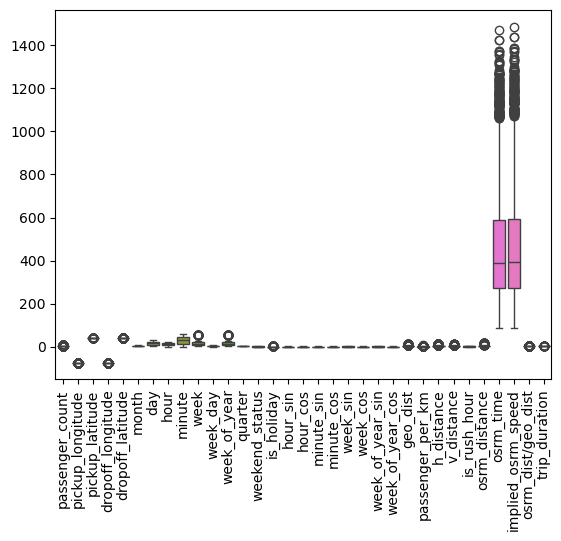

In [ ]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots()
sns.boxplot(train_concat)
plt.xticks(rotation=90)


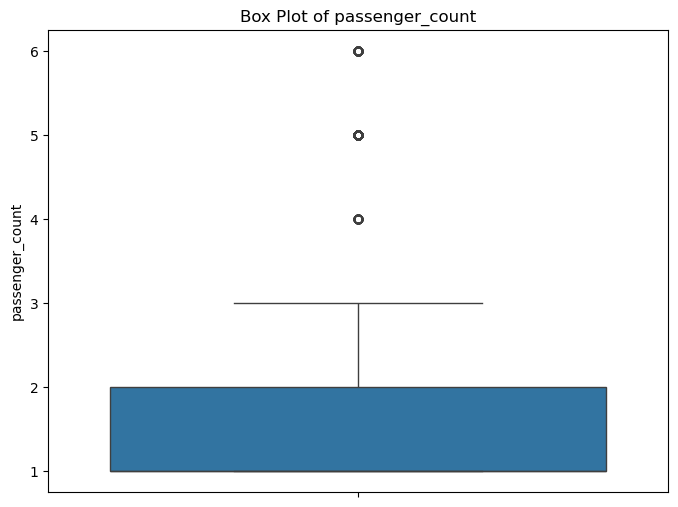

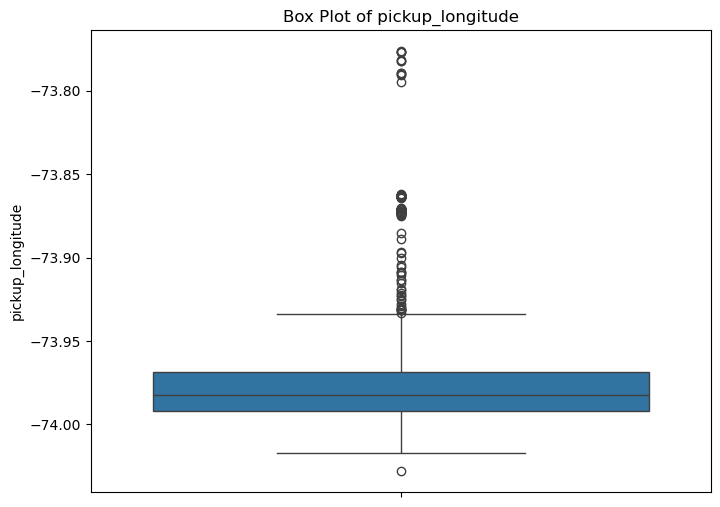

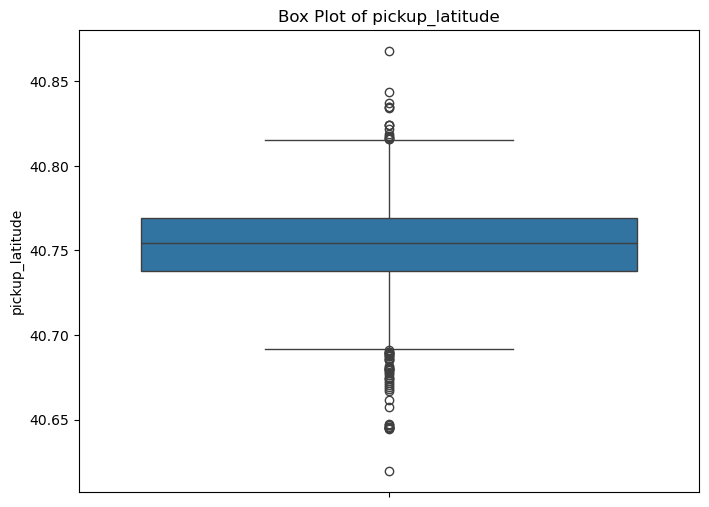

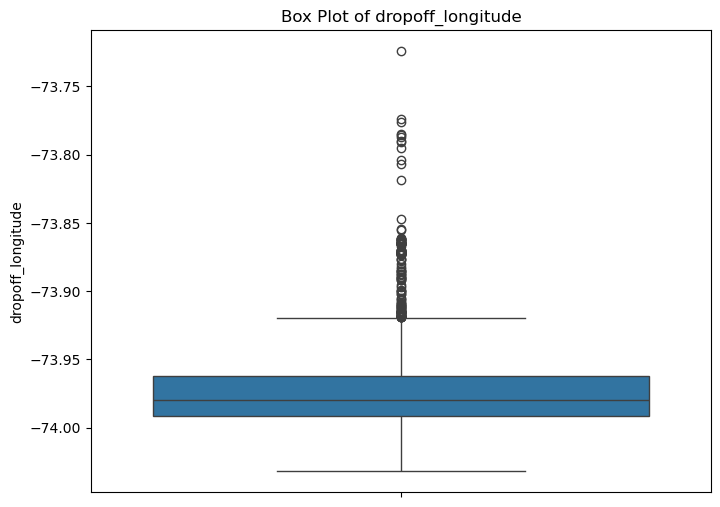

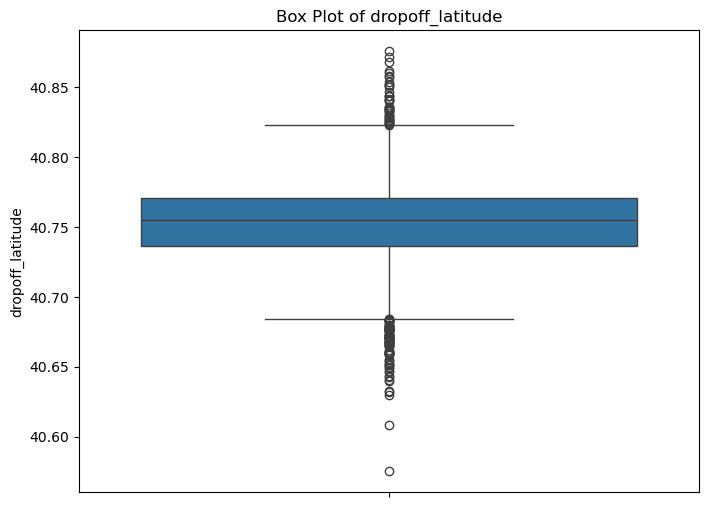

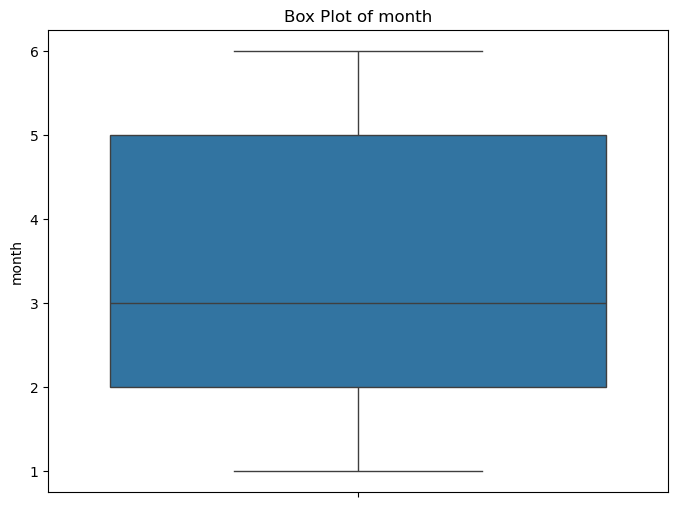

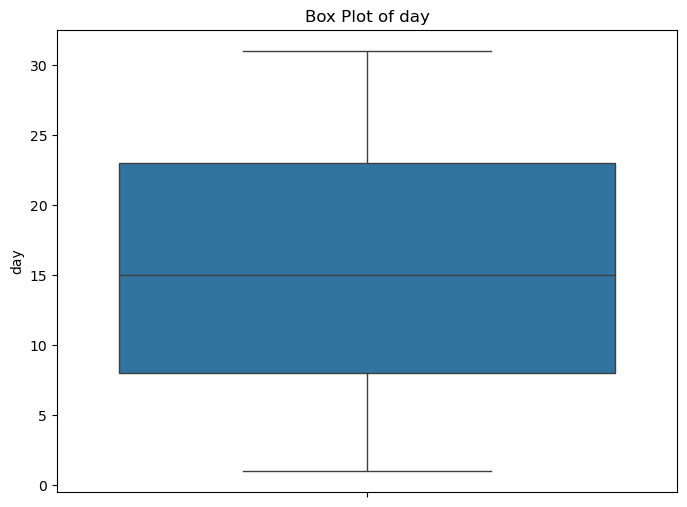

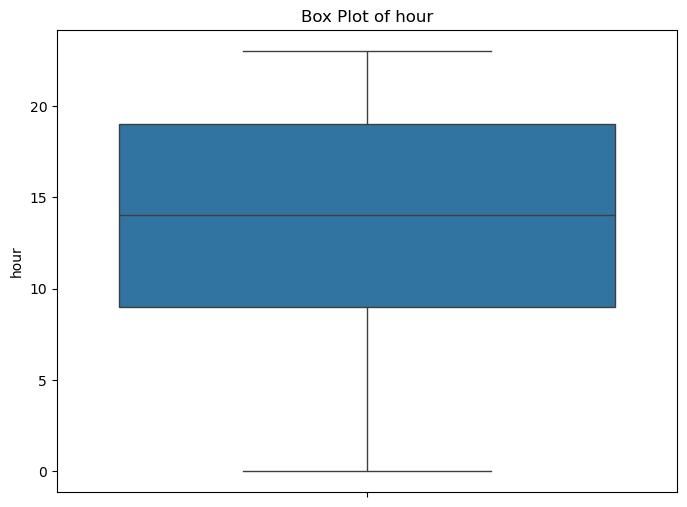

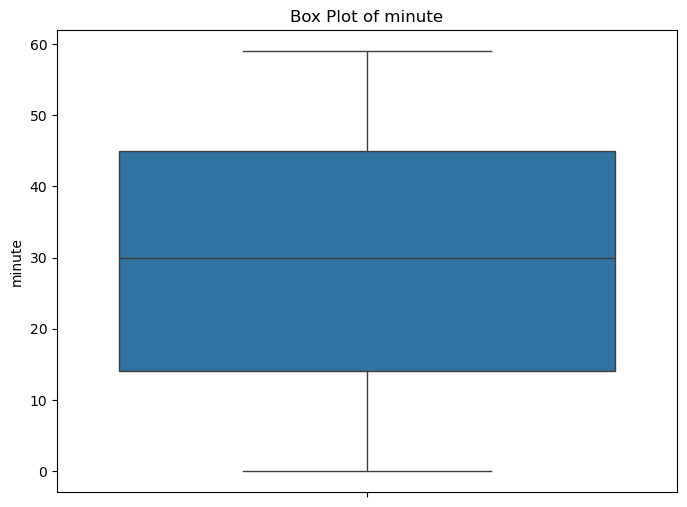

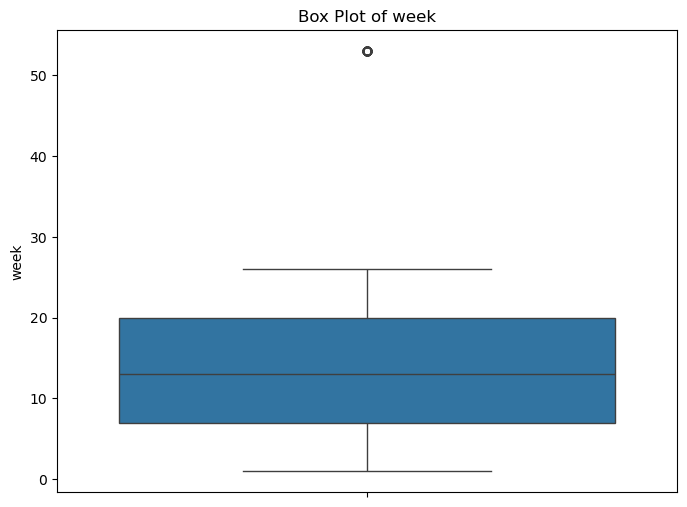

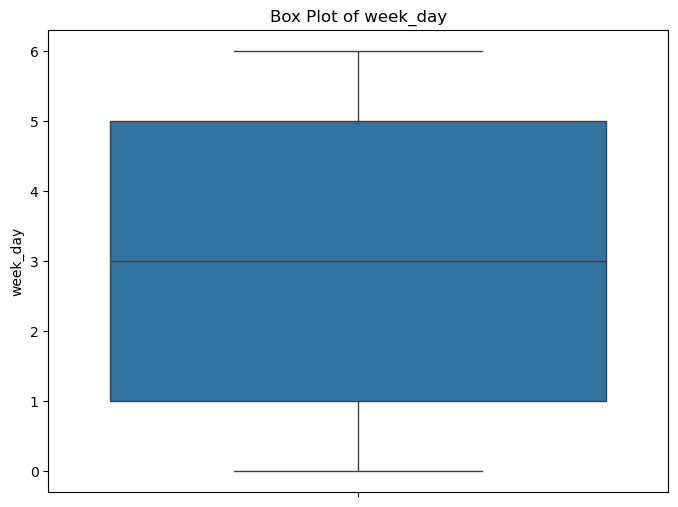

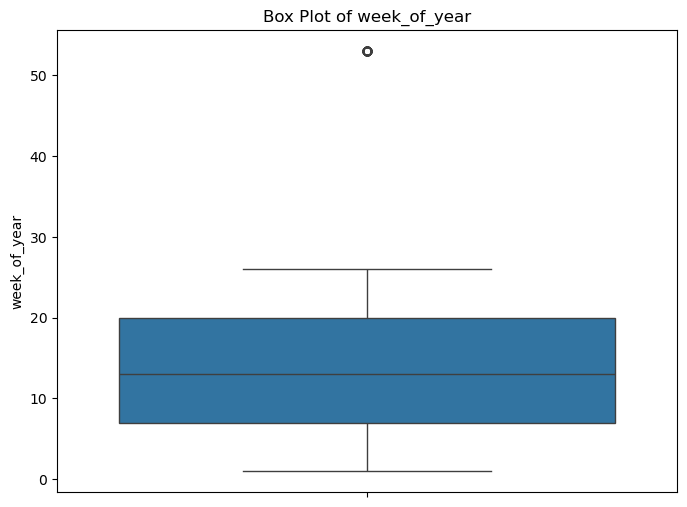

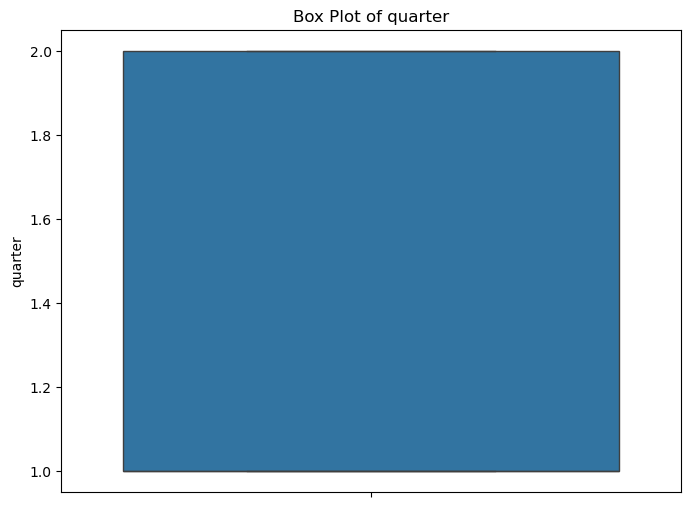

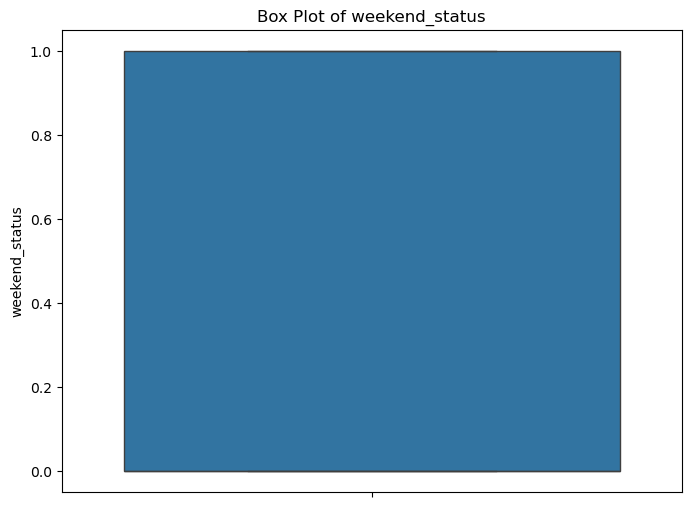

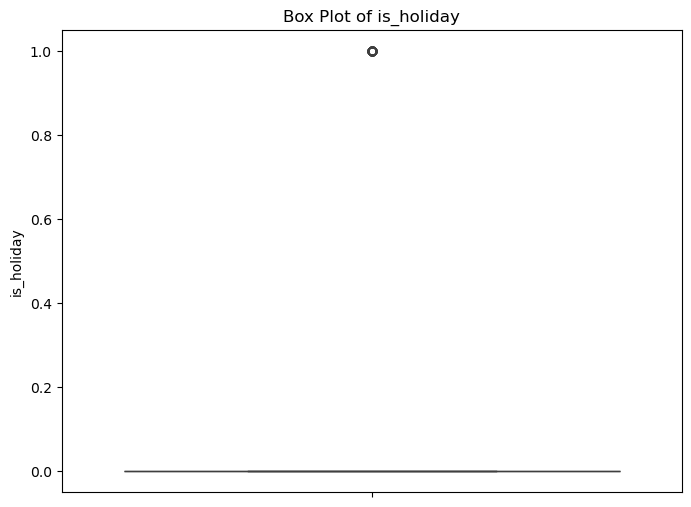

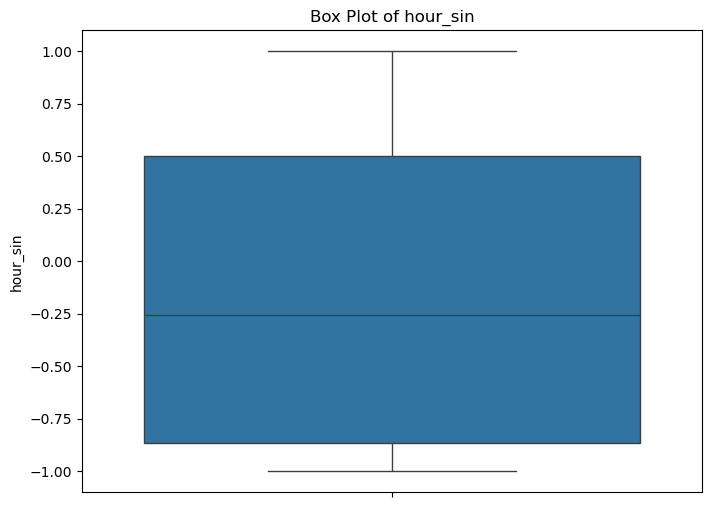

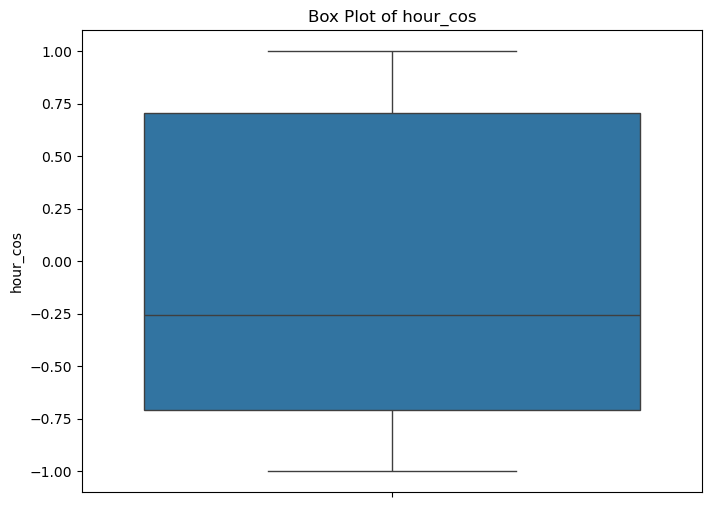

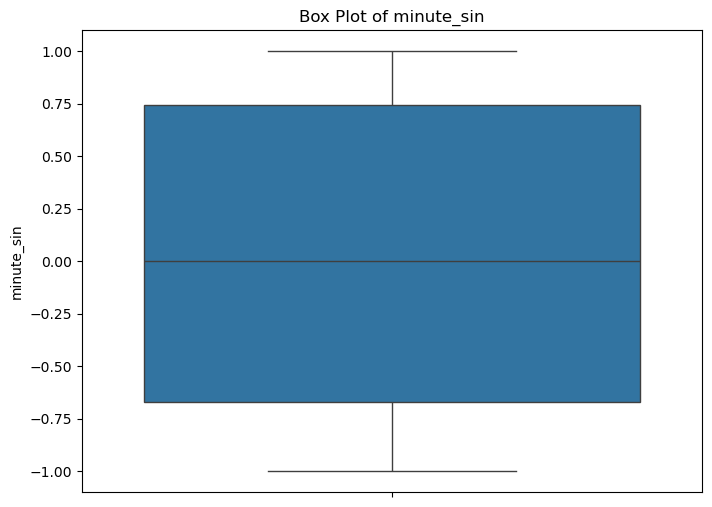

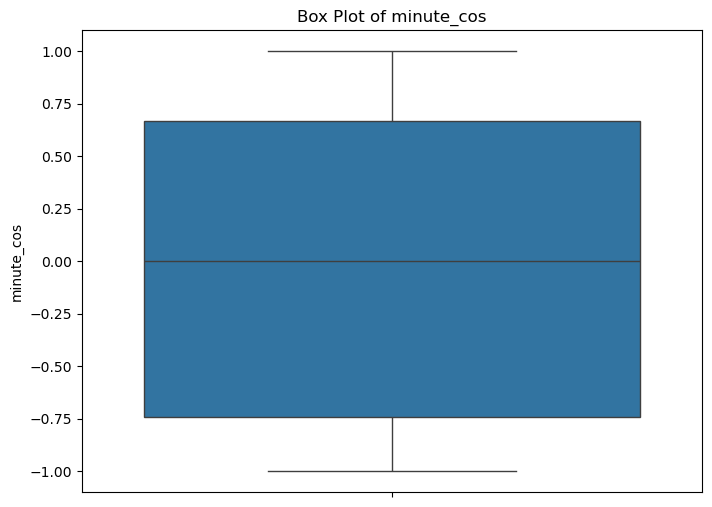

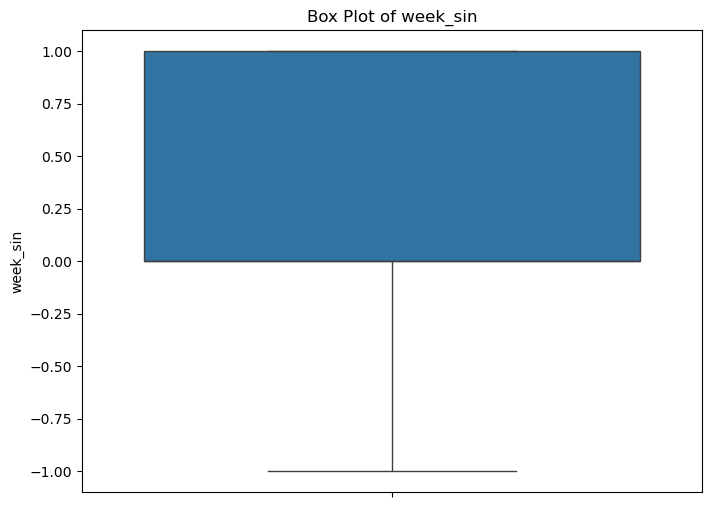

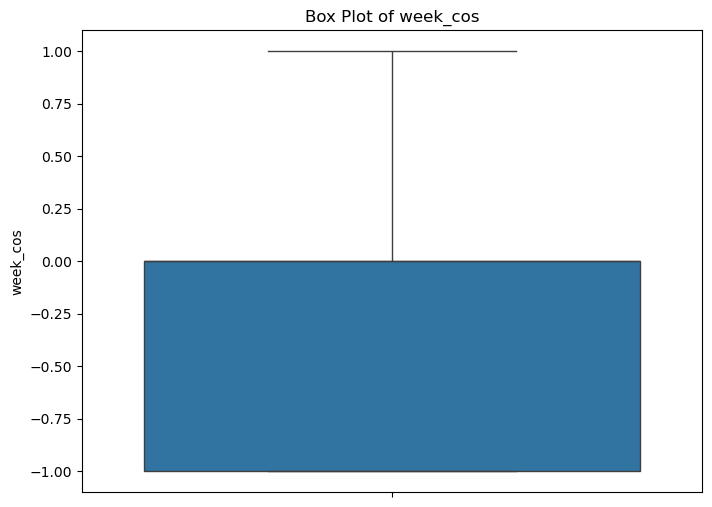

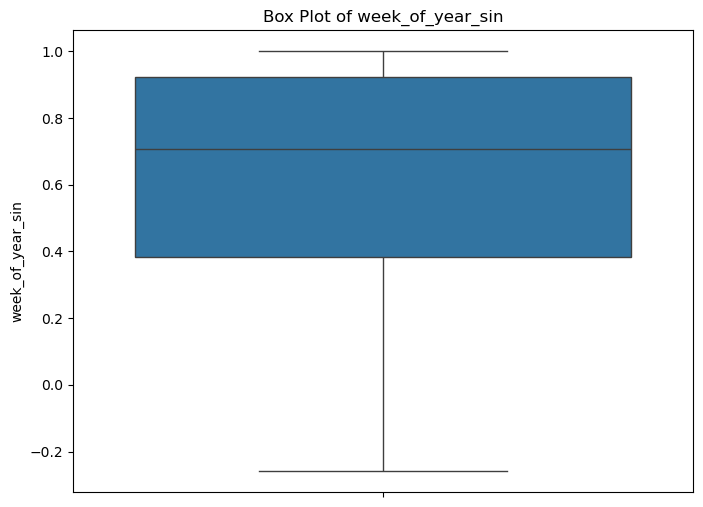

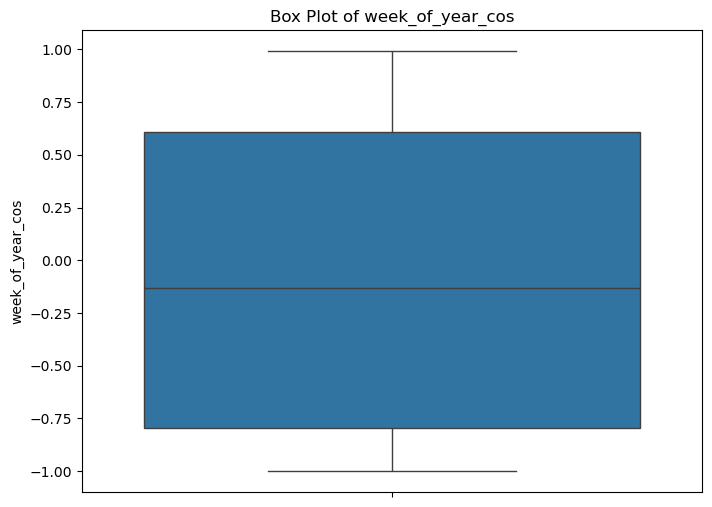

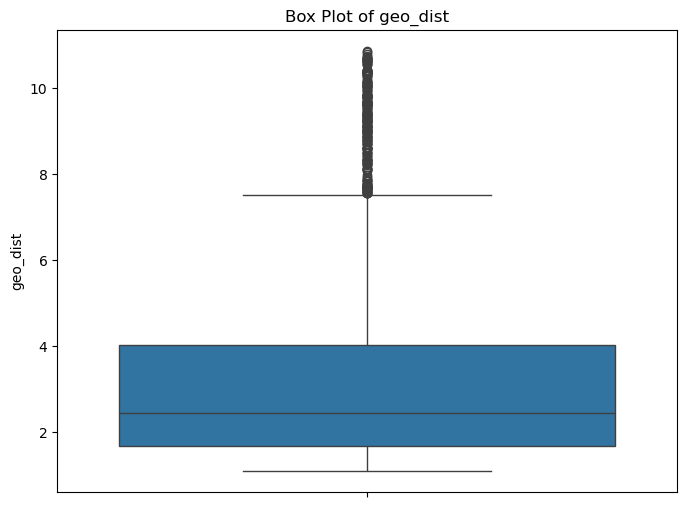

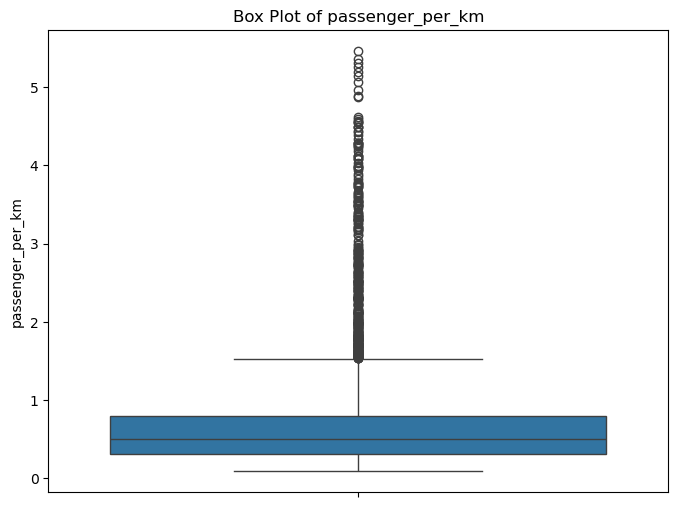

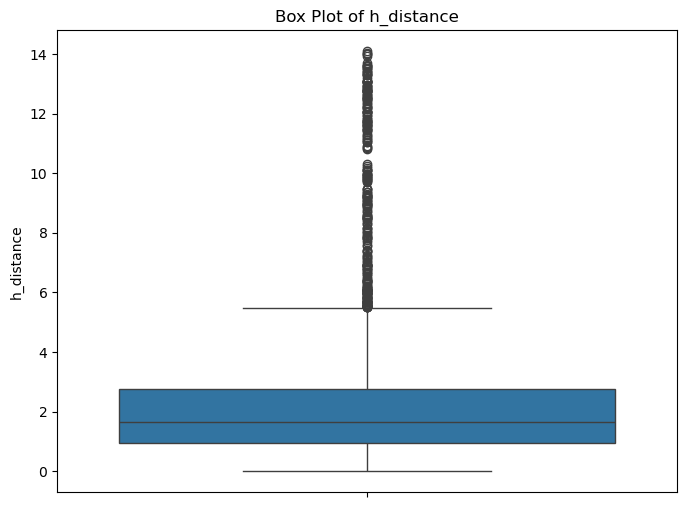

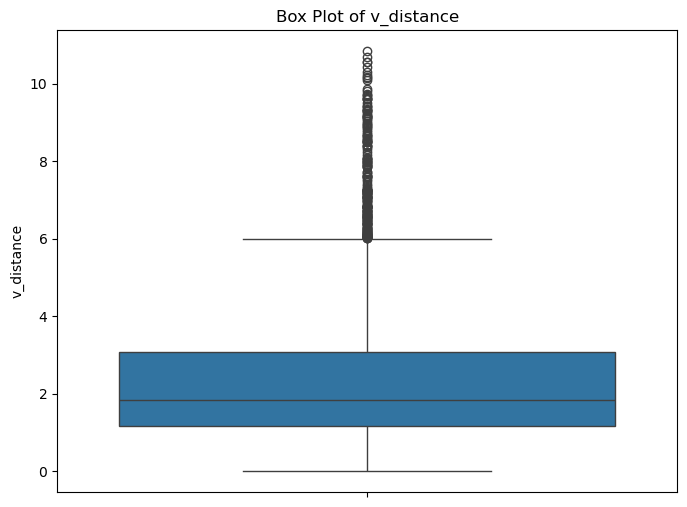

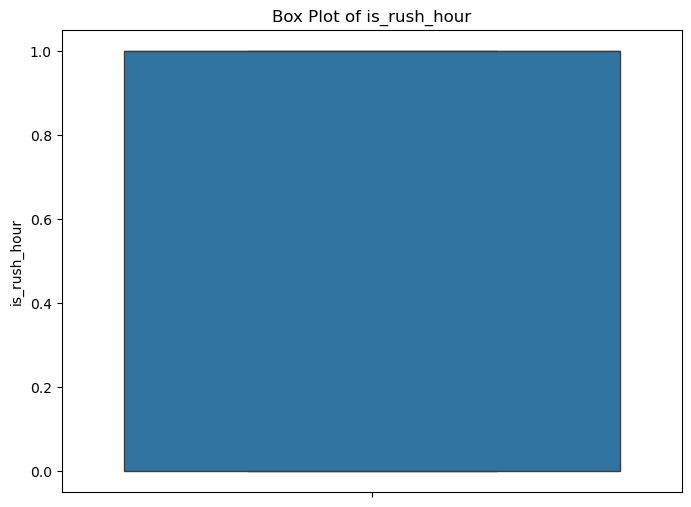

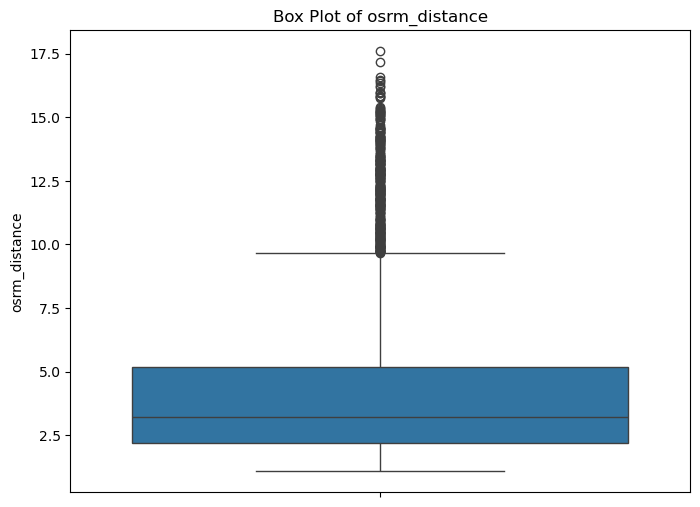

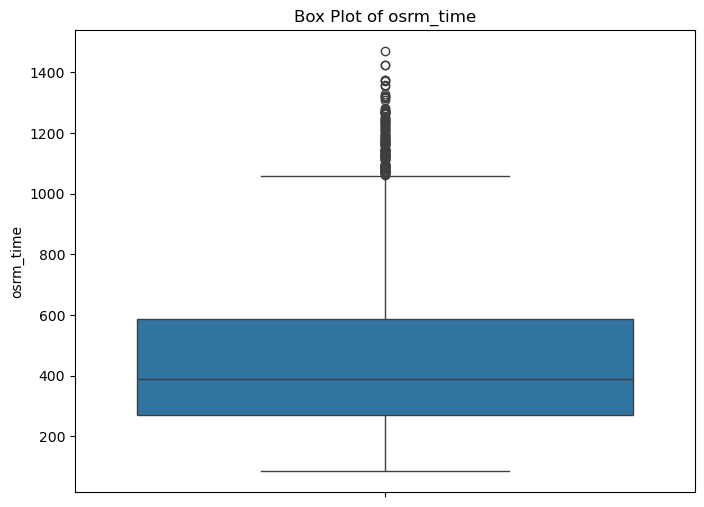

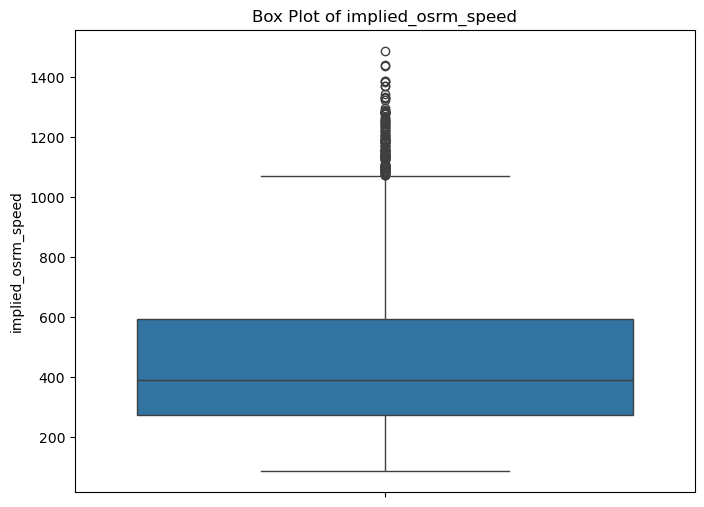

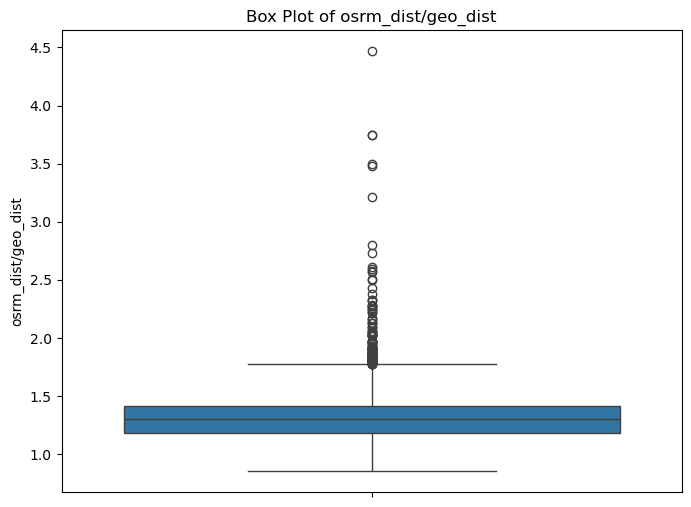

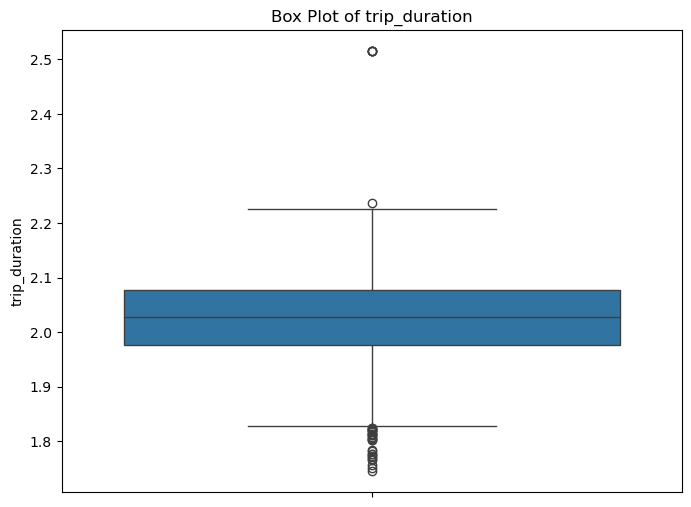

In [ ]:
for column in train_concat.columns:
    plt.figure(figsize=(8, 6))  # Adjust figure size as needed
    sns.boxplot(y=train_concat[column])
    plt.title(f"Box Plot of {column}")
    plt.ylabel(column)
    plt.show()

what to do next :
1. investigate one hot encoding the day over  the performance 
2. filter the outliers bases on the trip duration 


<Axes: >

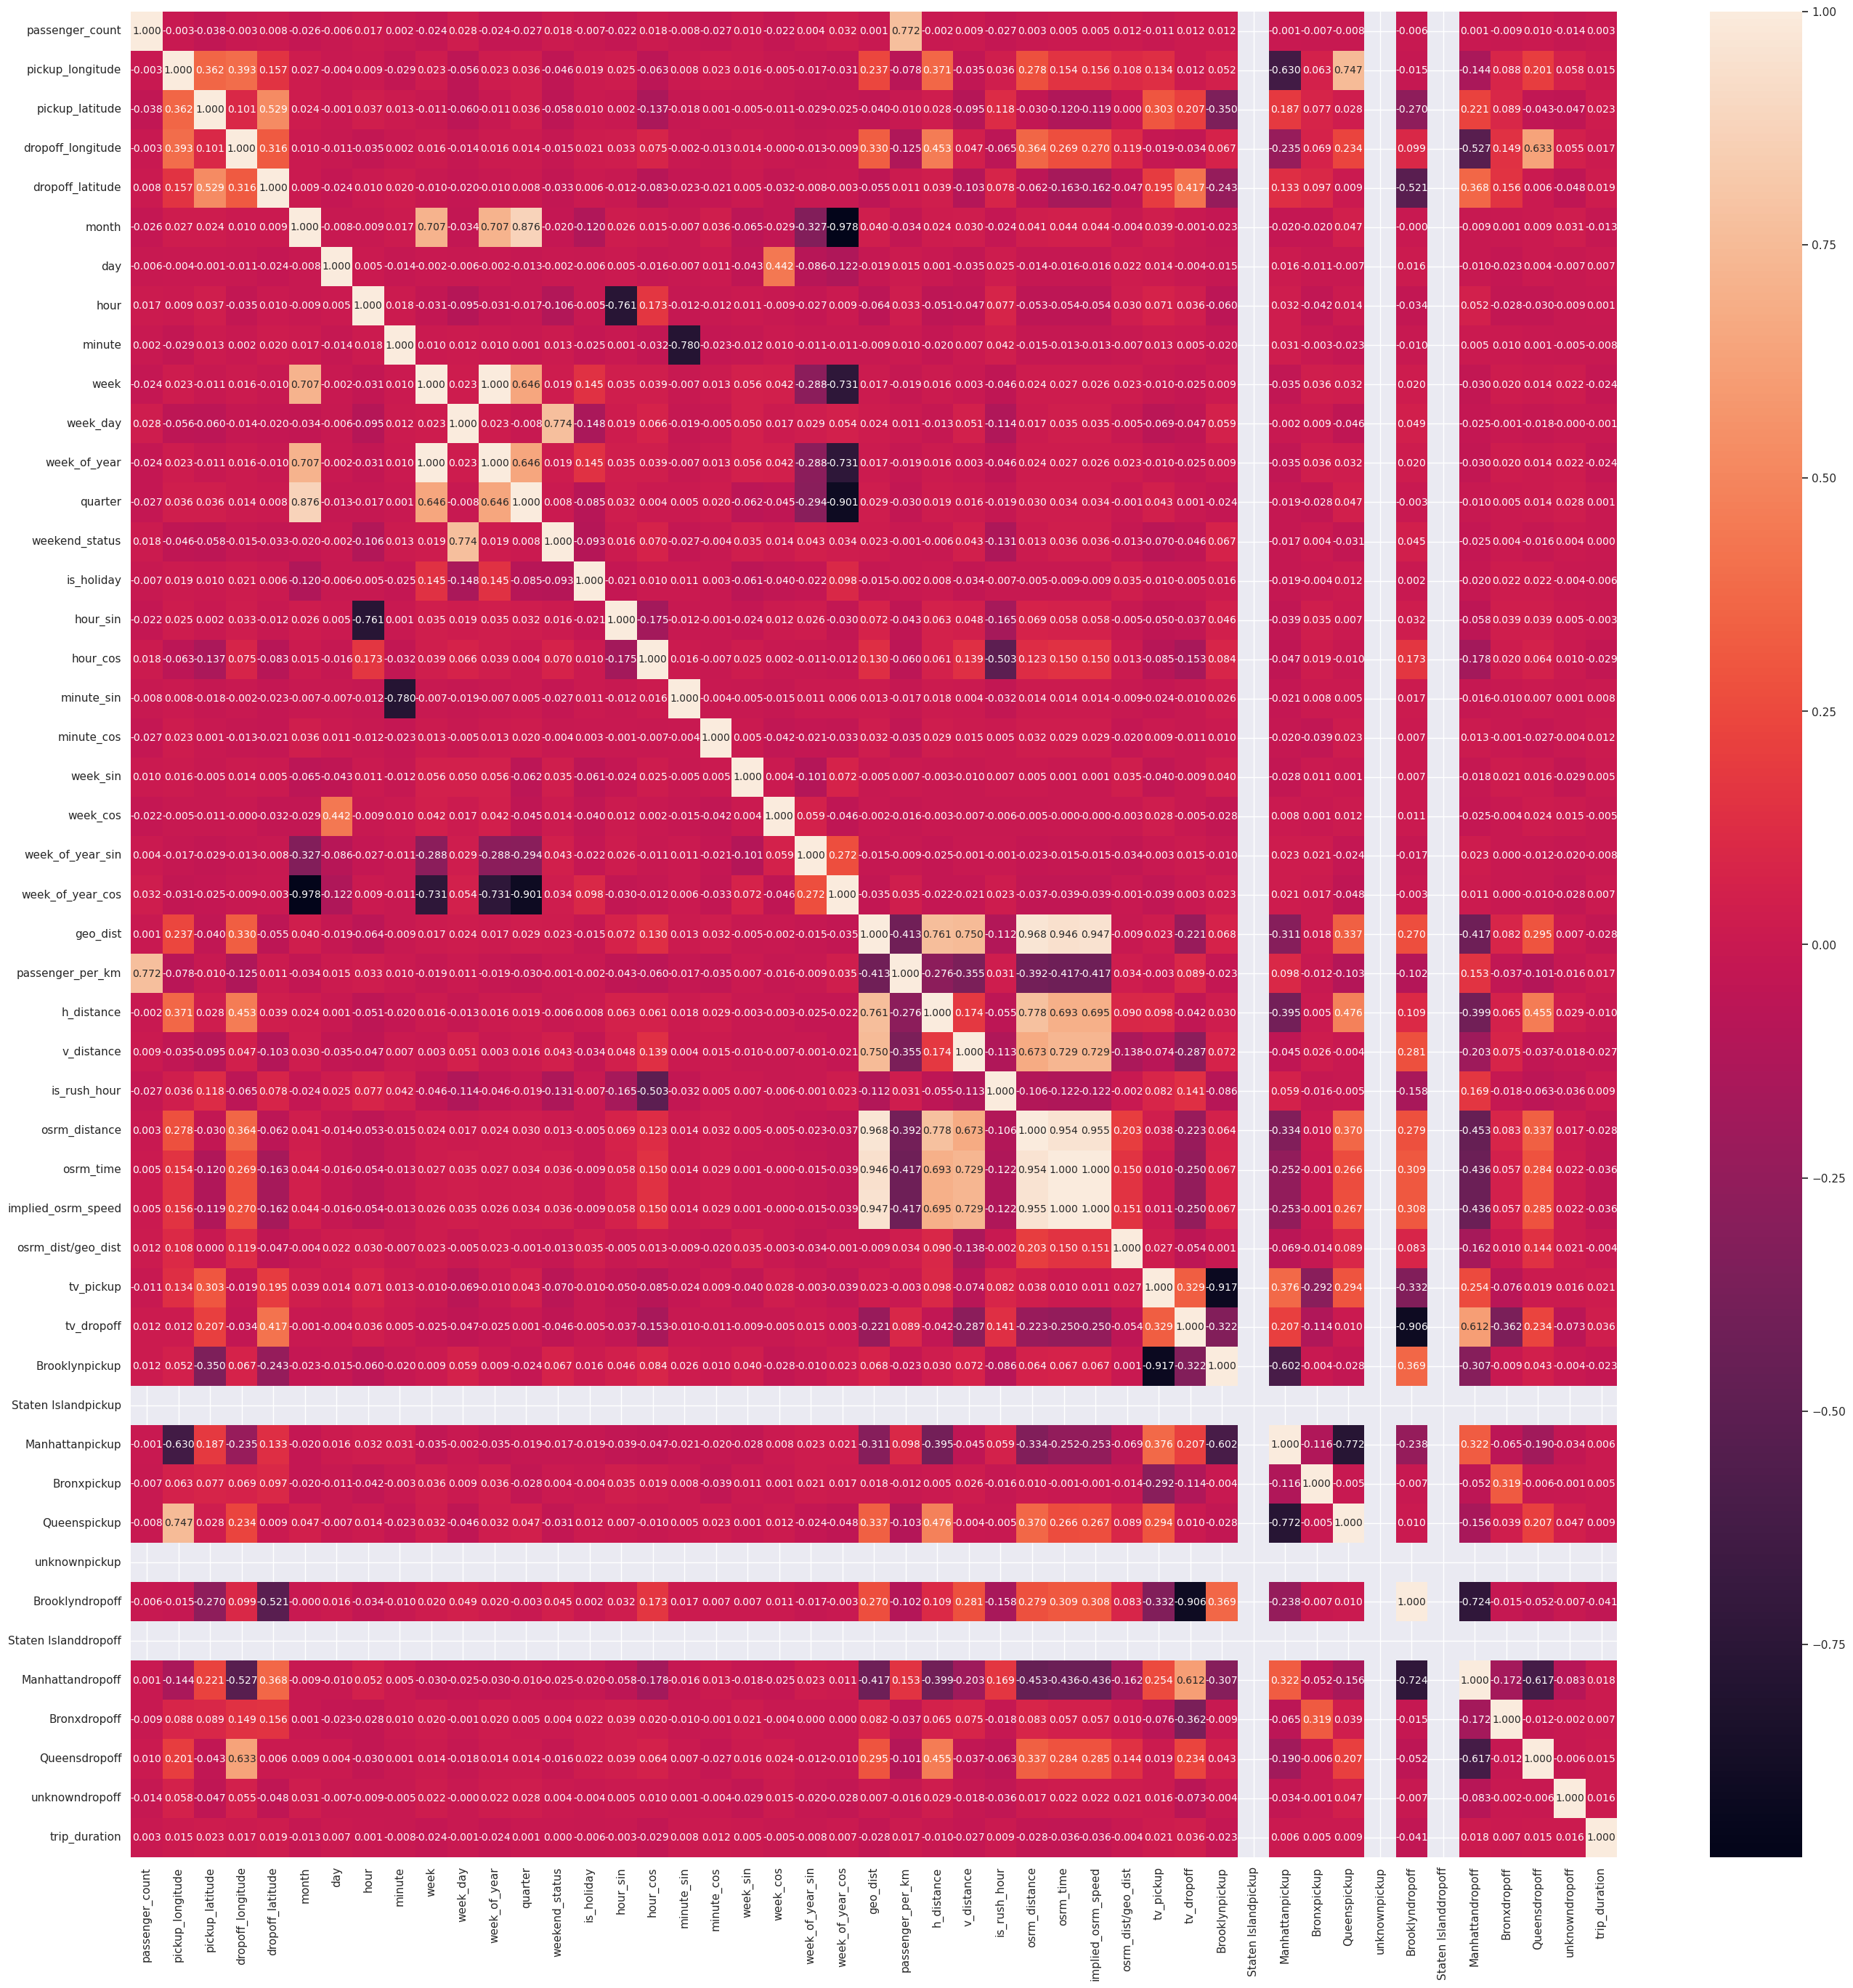

In [ ]:
corr_matrix = train_concat.corr()
fig, ax = plt.subplots(figsize=(33, 33))
sns.set(font_scale=1)
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt="0.3f",
    annot_kws={"size": 10},
    xticklabels=train_concat.columns,
    yticklabels=train_concat.columns,
)

In [ ]:
train_concat["week"] = train_df["pickup_datetime"].apply(lambda x: x.week)
train_concat["week_day"] = train_df["pickup_datetime"].apply(lambda x: x.day_of_week)
train_concat["week_of_year"] = train_df["pickup_datetime"].apply(lambda x: x.weekofyear)
train_concat["passenger_per_km"] = (
    train_concat["passenger_count"] / train_concat["geo_dist"]
)
train_concat["quarter"] = train_df["pickup_datetime"].apply(lambda x: x.quarter)
train_concat["weekend_status"] = train_df["pickup_datetime"].apply(
    lambda x: 1 if x.day_name() in ("Saturday", "Sunday") else 0
)
# if we were to filter outliers
train_concat = train_concat[
    train_concat.geo_dist <= train_concat["geo_dist"].quantile(0.95)
]

In [ ]:
train_concat.columns

Index(['passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'month', 'day', 'hour',
       'minute', 'week', 'week_day', 'week_of_year', 'quarter',
       'weekend_status', 'is_holiday', 'hour_sin', 'hour_cos', 'minute_sin',
       'minute_cos', 'week_sin', 'week_cos', 'week_of_year_sin',
       'week_of_year_cos', 'geo_dist', 'passenger_per_km', 'h_distance',
       'v_distance', 'is_rush_hour', 'osrm_distance', 'osrm_time',
       'implied_osrm_speed', 'osrm_dist/geo_dist', 'trip_duration'],
      dtype='object')

In [ ]:
train_concat.pickup_longitude[0], train_concat.pickup_latitude[0]

(-73.99064636230467, 40.751068115234375)

In [ ]:
train_concat.dropoff_longitude[0], train_concat.dropoff_latitude[0]

(-73.99578857421875, 40.728145599365234)

In [ ]:
train_concat.columns

Index(['passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'month', 'day', 'hour',
       'minute', 'week', 'week_day', 'week_of_year', 'quarter',
       'weekend_status', 'is_holiday', 'hour_sin', 'hour_cos', 'minute_sin',
       'minute_cos', 'week_sin', 'week_cos', 'week_of_year_sin',
       'week_of_year_cos', 'geo_dist', 'passenger_per_km', 'h_distance',
       'v_distance', 'is_rush_hour', 'osrm_distance', 'osrm_time',
       'implied_osrm_speed', 'osrm_dist/geo_dist', 'trip_duration'],
      dtype='object')

In [ ]:
np.log1p((9 * 60))

6.293419278846481

In [ ]:
import requests


def osrm_distance_time_estimate(row: pd.DataFrame):
    start = f"{row['pickup_longitude']},{row['pickup_latitude']}"
    end = f"{row['dropoff_longitude']},{row['dropoff_latitude']}"

    url = f"http://localhost:5000/route/v1/driving/{start};{end}?overview=false"
    response = requests.get(url)
    duration = None
    distance = None
    # Check if the request was successful
    if response.status_code == 200:
        data = response.json()
        routes = data.get("routes", [])
        if routes:
            route = routes[0]
            distance = route.get("distance", 0) / 1000  # in km
            duration = route.get("duration", 0)  # in seconds
    return (
        distance if distance else 3.2345,
        duration if duration else 848.857,
    )  # mean for trip duration in training data

In [ ]:
distance_time_estimate = train_df.apply(osrm_distance_time_estimate, axis=1)
distance, time = (
    distance_time_estimate.apply(lambda x: x[0]),
    distance_time_estimate.apply(lambda x: x[1]),
)

In [ ]:
# traffic_path ='Traffic_Volume_Counts.csv'
# traffic_df = load_data_into_df(traffic_path)
# traffic_df.set_index('ID')

In [ ]:
traffic_df.shape

NameError: name 'traffic_df' is not defined

In [ ]:
time_est_corr = np.corrcoef(
    time + epsilon, train_df["trip_duration"] + epsilon, rowvar=False
)
distance_corr = np.corrcoef(
    distance + epsilon, train_df["trip_duration"] + epsilon, rowvar=False
)

print(
    "time correlation", time_est_corr[0, 1], "distance correlation", distance_corr[0, 1]
)

time correlation 0.18716064740750918 distance correlation 0.18792567838631824


In [ ]:
train_data.shape

(5000, 21)

In [ ]:
index = 13
long_start = train_concat.pickup_longitude[index]
lat_start = train_concat.pickup_latitude[index]
long_end = train_concat.dropoff_longitude[index]
lat_end = train_concat.dropoff_latitude[index]

In [ ]:
# let's play with the api
start = f"{long_start},{lat_start}"
end = f"{long_end},{lat_end}"

url = f"http://localhost:5000/route/v1/driving/{start};{end}?overview=false&steps=true"
response = requests.get(url)
# duration = None
# distance = None
# # Check if the request was successful
# if response.status_code == 200:
#     data = response.json()
#     routes = data.get("routes", [])
#     if routes:
#         route = routes[0]
#         distance = route.get("distance", 0) / 1000  # in km
#         duration = route.get("duration", 0)  # in seconds

In [ ]:
data = response.json()
data.get("routes", [])

[{'legs': [{'steps': [{'intersections': [{'out': 0,
        'entry': [True],
        'bearings': [299],
        'location': [-73.953913, 40.77115]}],
      'driving_side': 'right',
      'geometry': 'ubzwF|bkbMeDhKK\\',
      'maneuver': {'bearing_after': 299,
       'bearing_before': 0,
       'location': [-73.953913, 40.77115],
       'type': 'depart'},
      'name': 'East 77th Street',
      'mode': 'driving',
      'weight': 30.1,
      'duration': 30.1,
      'distance': 204},
     {'intersections': [{'out': 2,
        'in': 1,
        'entry': [False, False, True, True],
        'bearings': [30, 120, 210, 300],
        'location': [-73.956027, 40.77204]},
       {'lanes': [{'valid': False, 'indications': ['left']},
         {'valid': False, 'indications': ['straight']},
         {'valid': False, 'indications': ['straight']},
         {'valid': False, 'indications': ['straight']},
         {'valid': True, 'indications': ['none']}],
        'out': 2,
        'in': 0,
        'entry

In [ ]:
routes = data.get("routes", [])
route = routes[0]
distance = route.get("distance", 0) / 1000  # in km
duration = route.get("duration", 0)  # in seconds

# Extract street names from steps
steps = route.get("legs", [])[0].get("steps", [])
street_names = [step.get("name", "") for step in steps if step.get("name")]

In [ ]:
street_names

['East 77th Street',
 '2nd Avenue',
 'East 72nd Street',
 '5th Avenue',
 '65th Street Transverse',
 'Central Park West',
 'West 63rd Street',
 'West 63rd Street']

In [ ]:
traffic_df.head()

,ID,SegmentID,Roadway Name,From,To,Direction,Date,12:00-1:00 AM,1:00-2:00AM,2:00-3:00AM,...,2:00-3:00PM,3:00-4:00PM,4:00-5:00PM,5:00-6:00PM,6:00-7:00PM,7:00-8:00PM,8:00-9:00PM,9:00-10:00PM,10:00-11:00PM,11:00-12:00AM
0,1,15540,BEACH STREET,UNION PLACE,VAN DUZER STREET,NB,01/09/2012,20,10,11.0,...,104,105,147,120,91,83,74,49,42,42
1,2,15540,BEACH STREET,UNION PLACE,VAN DUZER STREET,NB,01/10/2012,21,16,8.0,...,102,98,133,131,95,73,70,63,42,35
2,3,15540,BEACH STREET,UNION PLACE,VAN DUZER STREET,NB,01/11/2012,27,14,6.0,...,115,115,130,143,106,89,68,64,56,43
3,4,15540,BEACH STREET,UNION PLACE,VAN DUZER STREET,NB,01/12/2012,22,7,7.0,...,71,127,122,144,122,76,64,58,64,43
4,5,15540,BEACH STREET,UNION PLACE,VAN DUZER STREET,NB,01/13/2012,31,17,7.0,...,113,126,133,135,102,106,58,58,55,54


In [ ]:
# roadway_names = set(traffic_df["Roadway Name"].unique())
# _from = set(traffic_df.From.unique())
# to = set(traffic_df.To.unique())

In [ ]:
for name in street_names:
    print(name if (name is roadway_names or name in _from or name in to) else False)

NameError: name 'street_names' is not defined

In [ ]:
automated_traffic_df = load_data_into_df("Automated_Traffic_Volume_Counts.csv")

In [ ]:
automated_traffic_df.head()

,RequestID,Boro,Yr,M,D,HH,MM,Vol,SegmentID,WktGeom,street,fromSt,toSt,Direction
0,32970,Queens,2021,4,30,2,0,0,149701,POINT (997407.0998491726 208620.92612708386),PULASKI BRIDGE,Newtown Creek Shoreline,Dead end,NB
1,32970,Queens,2021,4,30,2,15,1,149701,POINT (997407.0998491726 208620.92612708386),PULASKI BRIDGE,Newtown Creek Shoreline,Dead end,NB
2,11342,Brooklyn,2012,12,18,8,15,33,20063,POINT (985746.5 167127.4),61 ST,15 AV,16 AV,WB
3,32970,Queens,2021,4,30,2,30,0,149701,POINT (997407.0998491726 208620.92612708386),PULASKI BRIDGE,Newtown Creek Shoreline,Dead end,NB
4,32970,Queens,2021,4,30,2,45,0,149701,POINT (997407.0998491726 208620.92612708386),PULASKI BRIDGE,Newtown Creek Shoreline,Dead end,NB


In [ ]:
subset = automated_traffic_df[automated_traffic_df.Yr == 2016]
subset.head()


,RequestID,Boro,Yr,M,D,HH,MM,Vol,SegmentID,WktGeom,street,fromSt,toSt,Direction
1915,23360,Queens,2016,6,13,0,0,7,66303,POINT (1003204.0046622645 209834.15302233098),47 avenue,33 Street,34 Street,EB
1916,23360,Queens,2016,6,13,0,15,6,66303,POINT (1003204.0046622645 209834.15302233098),47 avenue,33 Street,34 Street,EB
1917,23360,Queens,2016,6,13,0,30,6,66303,POINT (1003204.0046622645 209834.15302233098),47 avenue,33 Street,34 Street,EB
1918,23360,Queens,2016,6,13,0,45,7,66303,POINT (1003204.0046622645 209834.15302233098),47 avenue,33 Street,34 Street,EB
1919,23360,Queens,2016,6,13,1,0,8,66303,POINT (1003204.0046622645 209834.15302233098),47 avenue,33 Street,34 Street,EB


In [ ]:
subset[subset.Boro == "Queens"].head()

,RequestID,Boro,Yr,M,D,HH,MM,Vol,SegmentID,WktGeom,street,fromSt,toSt,Direction
1915,23360,Queens,2016,6,13,0,0,7,66303,POINT (1003204.0046622645 209834.15302233098),47 avenue,33 Street,34 Street,EB
1916,23360,Queens,2016,6,13,0,15,6,66303,POINT (1003204.0046622645 209834.15302233098),47 avenue,33 Street,34 Street,EB
1917,23360,Queens,2016,6,13,0,30,6,66303,POINT (1003204.0046622645 209834.15302233098),47 avenue,33 Street,34 Street,EB
1918,23360,Queens,2016,6,13,0,45,7,66303,POINT (1003204.0046622645 209834.15302233098),47 avenue,33 Street,34 Street,EB
1919,23360,Queens,2016,6,13,1,0,8,66303,POINT (1003204.0046622645 209834.15302233098),47 avenue,33 Street,34 Street,EB


In [ ]:
subset.HH.unique()

<ArrowExtensionArray>
[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
 19, 20, 21, 22, 23]
Length: 24, dtype: int64[pyarrow]

In [ ]:
# streets = subset.street.unique()
# from_st = subset.fromSt.unique()
# to_st = subset.toSt.unique()
# for street in street_names:
#      print(street if street in streets or street in from_st or street in to_st else False)
clean_data.hour.unique()

array([18,  8, 17, 10, 20,  0, 21, 23, 22,  7, 15, 11,  9, 16,  5, 14, 13,
        2, 19, 12,  3,  6,  1,  4])

In [ ]:
# saving the subset
subset.to_csv("Traffic_Volume_Counts_2016.csv")

In [ ]:
# borough_df = load_data_into_df('Borough_Boundaries.csv')
# borough_df.head()

In [103]:
boro_df = pd.read_csv("Borough_Boundaries.csv")
boro_df.set_index("BoroCode", inplace=True)
boro_df.head()

,BoroName,Shape_Area,Shape_Length,the_geom
BoroCode,,,,
3,Brooklyn,1.934143e+09,728150.705111,MULTIPOLYGON (((-73.86327471071941 40.58387684...
5,Staten Island,1.623619e+09,325910.306061,MULTIPOLYGON (((-74.05050806403247 40.56642203...
1,Manhattan,6.366456e+08,360056.730857,MULTIPOLYGON (((-74.01092841268031 40.68449147...
2,Bronx,1.187175e+09,463180.578878,MULTIPOLYGON (((-73.89680883223778 40.79580844...
4,Queens,3.041418e+09,888197.010944,MULTIPOLYGON (((-73.82644661516991 40.59052744...


In [ ]:
from shapely import Polygon


In [ ]:
string

'MULTIPOLYGON (((-73.86327471071941 40.58387684853188, -73.8638123946195 40.583604003588746, -73.86449245335685 40.58361493817881, -73.86503589278036 40.58330206008568, -73.86557925292553 40.583026802455024, -73.86637619312663 40.582538657867545, -73.86700232991268 40.58197708027551, -73.8677279690368 40.581663409428856, -73.8689509792262 40.58171354212267, -73.86896292210412 40.58169379478863, -73.86925758051295 40.58190964057089, -73.86968631043702 40.58230878579192, -73.87000313643009 40.58263661431334, -73.87034778401303 40.58306413703528, -73.87050597918449 40.58334195251119, -73.87051388095942 40.58408232690068, -73.87061497794411 40.58491535106041, -73.87084743947628 40.58542105412849, -73.87099791648033 40.58606179786278, -73.87115922675414 40.58687388796734, -73.86981356482104 40.58946092678829, -73.86849671647202 40.59008985028965, -73.8675927577521 40.591005791690705, -73.86690268173955 40.59147303544141, -73.86635052164085 40.59189267656481, -73.86476222962085 40.5914922185

In [ ]:
import shapely.wkt

boro_df["the_geom"] = boro_df.the_geom.apply(lambda x: shapely.wkt.loads(x))
type(boro_df["the_geom"].iloc[0])

shapely.geometry.multipolygon.MultiPolygon

In [ ]:
from shapely import Point

In [ ]:
longt = clean_data.pickup_longitude[0]
latitude = clean_data.dropoff_latitude[0]
point = Point(longt, latitude)

check = boro_df["the_geom"].apply(lambda x: point.within(x))
test = boro_df[check]["BoroName"].values[0]
test

'Manhattan'

In [ ]:
boro_df[["BoroName", "Shape_Length"]]

,BoroName,Shape_Length
BoroCode,,
3,Brooklyn,728150.705111
5,Staten Island,325910.306061
1,Manhattan,360056.730857
2,Bronx,463180.578878
4,Queens,888197.010944


In [ ]:
test

'2    Manhattan'

In [ ]:
boro_df[check]["BoroName"].reset_index()["BoroName"]

0    Manhattan
Name: BoroName, dtype: object

In [ ]:
boro_df.BoroName.unique()

array(['Brooklyn', 'Staten Island', 'Manhattan', 'Bronx', 'Queens'],
      dtype=object)

In [ ]:
train_data = load_data_into_df(train_path)


def boro(row, col="pickup"):
    from shapely import Point

    if col == "pickup":
        point = Point(row.pickup_longitude, row.pickup_latitude)
    else:
        point = Point(row.dropoff_longitude, row.dropoff_latitude)

    check = boro_df["the_geom"].apply(lambda x: point.within(x))
    # print(type(boro_df[check]["BoroName"].values))
    # return np.array2string( boro_df[check]["BoroName"].values)
    neighbor = "".join(map(str, boro_df[check]["BoroName"].values))
    return neighbor if neighbor else "unknown"


train_data["pickup_boro"] = train_data[["pickup_longitude", "pickup_latitude"]].apply(
    boro, axis=1
)
# )
train_data["dropoff_boro"] = train_data[
    ["dropoff_longitude", "dropoff_latitude"]
].apply(boro, args=("dropoff",), axis=1)

In [ ]:
train_data.pickup_boro.unique()

array(['Manhattan', 'Queens', 'Brooklyn', 'unknown', 'Bronx'],
      dtype=object)

In [ ]:
train_data.pickup_boro.head(), train_data.dropoff_boro.head()

(0    Manhattan
 1    Manhattan
 2    Manhattan
 3    Manhattan
 4    Manhattan
 Name: pickup_boro, dtype: object,
 0    Manhattan
 1    Manhattan
 2    Manhattan
 3    Manhattan
 4    Manhattan
 Name: dropoff_boro, dtype: object)

In [ ]:
categories = ["Brooklyn", "Staten Island", "Manhattan", "Bronx", "Queens", "unknown"]
encoder = OneHotEncoder(sparse_output=False)
results = encoder.fit_transform(train_data["pickup_boro"].to_numpy().reshape(-1, 1))
# categories =[ category+'Pickup' for category  in encoder.categories_  if category]
df = pd.DataFrame(results, columns=categories)
new_data = pd.concat([train_data, df])

ValueError: Shape of passed values is (5000, 5), indices imply (5000, 6)

In [ ]:
encoder.categories_

[array(['', 'Bronx', 'Brooklyn', 'Manhattan', 'Queens'], dtype=object)]

In [ ]:
df = pd.DataFrame(results, columns=categories)
new_data = pd.concat([train_data, df])
df.drop
df.head()

,Brooklyn,Staten Island,Manhattan,Bronx,Queens
0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,1.0,0.0


In [ ]:
new_data = pd.concat([train_data, df])

In [ ]:
new_data.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_boro,dropoff_boro,"(,)","(Bronx,)","(Brooklyn,)","(Manhattan,)","(Queens,)"
0,id1385950,1,2016-01-08 22:31:12,1,-73.990646,40.751068,-73.995789,40.728146,N,525,Manhattan,Manhattan,NaN,NaN,NaN,NaN,NaN
1,id1885523,2,2016-01-02 12:36:39,1,-73.982658,40.745071,-74.003258,40.732971,N,799,Manhattan,Manhattan,NaN,NaN,NaN,NaN,NaN
2,id0892204,2,2016-02-21 00:24:16,1,-73.999481,40.72858,-74.000252,40.7188,N,374,Manhattan,Manhattan,NaN,NaN,NaN,NaN,NaN
3,id2463973,2,2016-05-08 15:06:34,1,-73.977058,40.75985,-73.949989,40.776001,N,696,Manhattan,Manhattan,NaN,NaN,NaN,NaN,NaN
4,id1496105,2,2016-05-06 13:54:36,2,-73.977798,40.758221,-73.99308,40.74313,N,703,Manhattan,Manhattan,NaN,NaN,NaN,NaN,NaN


In [ ]:
boro_df.BoroName.unique()

array(['Brooklyn', 'Staten Island', 'Manhattan', 'Bronx', 'Queens'],
      dtype=object)

In [ ]:
def one_hot_encode(data):
    categories = [
        ["Brooklyn", "Staten Island", "Manhattan", "Bronx", "Queens", "unknown"]
    ]
    encoder = OneHotEncoder(sparse_output=False, categories=categories, dtype=int)
    pickup = encoder.fit_transform(data["pickup_boro"].to_numpy().reshape(-1, 1))
    pick_up_categories = [category + "pickup" for category in categories[0]]
    pickup_df = pd.DataFrame(pickup, columns=pick_up_categories)
    # print(pickup_df.head())
    print(pickup_df.isna().sum())

    # drop off
    dropoff = encoder.transform(data["dropoff_boro"].to_numpy().reshape(-1, 1))
    dropoff_categories = [category + "dropoff" for category in categories[0]]
    dropoff_df = pd.DataFrame(dropoff, columns=dropoff_categories)
    print("drop off ")
    print(dropoff_df.isna().sum())
    # print(dropoff_df.head())

    return pd.concat([data, pickup_df, dropoff_df], axis=1)

In [ ]:
new_data = one_hot_encode(train_data)

Brooklynpickup         0
Staten Islandpickup    0
Manhattanpickup        0
Bronxpickup            0
Queenspickup           0
unknownpickup          0
dtype: int64
drop off 
Brooklyndropoff         0
Staten Islanddropoff    0
Manhattandropoff        0
Bronxdropoff            0
Queensdropoff           0
unknowndropoff          0
dtype: int64


In [ ]:
new_data.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,...,Manhattanpickup,Bronxpickup,Queenspickup,unknownpickup,Brooklyndropoff,Staten Islanddropoff,Manhattandropoff,Bronxdropoff,Queensdropoff,unknowndropoff
0,id1385950,1,2016-01-08 22:31:12,1,-73.990646,40.751068,-73.995789,40.728146,N,525,...,1,0,0,0,0,0,1,0,0,0
1,id1885523,2,2016-01-02 12:36:39,1,-73.982658,40.745071,-74.003258,40.732971,N,799,...,1,0,0,0,0,0,1,0,0,0
2,id0892204,2,2016-02-21 00:24:16,1,-73.999481,40.72858,-74.000252,40.7188,N,374,...,1,0,0,0,0,0,1,0,0,0
3,id2463973,2,2016-05-08 15:06:34,1,-73.977058,40.75985,-73.949989,40.776001,N,696,...,1,0,0,0,0,0,1,0,0,0
4,id1496105,2,2016-05-06 13:54:36,2,-73.977798,40.758221,-73.99308,40.74313,N,703,...,1,0,0,0,0,0,1,0,0,0


In [ ]:
for column in tuple(
    column
    for column in new_data.columns
    if column.endswith("pickup") or column.endswith("dropoff")
):
    print(new_data[f"{column}"].unique(), len(new_data[f"{column}"].unique()))

[0 1] 2
[0] 1
[1 0] 2
[0 1] 2
[0 1] 2
[0 1] 2
[0 1] 2
[0 1] 2
[1 0] 2
[0 1] 2
[0 1] 2
[0 1] 2


In [60]:
# now we need to work with traffic volume
tf_df = load_data_into_df("Traffic_Volume_Counts_2016.csv")

In [61]:
tf_df = tf_df[["Boro", "M", "D", "HH", "Vol"]]
new_tf = tf_df.groupby(["Boro", "M", "D", "HH"]).agg("sum")
# neighbor  , month , day , hour
new_tf.loc[("Bronx", 1, 4, 1)]

new_tf.shape

(13210, 1)

In [ ]:
np.average(new_tf["Vol"])

1002.035352006056

In [ ]:
("Bronx", 1, 4, 1) in new_tf.index

True

In [ ]:
# neighbor  , month , day , hour
new_tf.loc[("Bronx", 1, 4, 1)]

Vol    343
Name: (Bronx, 1, 4, 1), dtype: int64[pyarrow]

In [ ]:
sorted(train_data.columns)

['Bronxdropoff',
 'Bronxpickup',
 'Brooklyndropoff',
 'Brooklynpickup',
 'Manhattandropoff',
 'Manhattanpickup',
 'Queensdropoff',
 'Queenspickup',
 'Staten Islanddropoff',
 'Staten Islandpickup',
 'day',
 'dropoff_latitude',
 'dropoff_longitude',
 'geo_dist',
 'h_distance',
 'hour',
 'hour_cos',
 'hour_sin',
 'implied_osrm_speed',
 'is_holiday',
 'is_rush_hour',
 'minute',
 'minute_cos',
 'minute_sin',
 'month',
 'osrm_dist/geo_dist',
 'osrm_distance',
 'osrm_time',
 'passenger_count',
 'passenger_per_km',
 'pickup_latitude',
 'pickup_longitude',
 'quarter',
 'trip_duration',
 'unknowndropoff',
 'unknownpickup',
 'v_distance',
 'week',
 'week_cos',
 'week_day',
 'week_of_year',
 'week_of_year_cos',
 'week_of_year_sin',
 'week_sin',
 'weekend_status']

In [ ]:
def boro(row, col="pickup"):
    from shapely import Point

    if col == "pickup":
        point = Point(row.pickup_longitude, row.pickup_latitude)
    else:
        point = Point(row.dropoff_longitude, row.dropoff_latitude)

    check = boro_df["the_geom"].apply(lambda x: point.within(x))
    # print(type(boro_df[check]["BoroName"].values))
    # return np.array2string( boro_df[check]["BoroName"].values)
    neighbor = "".join(map(str, boro_df[check]["BoroName"].values))
    return neighbor if neighbor else "unknown"


train_data["pickup_boro"] = train_data[["pickup_longitude", "pickup_latitude"]].apply(
    boro, axis=1
)
# )
train_data["dropoff_boro"] = train_data[
    ["dropoff_longitude", "dropoff_latitude"]
].apply(boro, args=("dropoff",), axis=1)


In [ ]:
train_data.columns

Index(['passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'trip_duration', 'month',
       'day', 'hour', 'minute', 'week', 'week_day', 'week_of_year', 'quarter',
       'weekend_status', 'is_holiday', 'hour_sin', 'hour_cos', 'minute_sin',
       'minute_cos', 'week_sin', 'week_cos', 'week_of_year_sin',
       'week_of_year_cos', 'geo_dist', 'passenger_per_km', 'h_distance',
       'v_distance', 'is_rush_hour', 'osrm_distance', 'osrm_time',
       'implied_osrm_speed', 'osrm_dist/geo_dist', 'Brooklynpickup',
       'Staten Islandpickup', 'Manhattanpickup', 'Bronxpickup', 'Queenspickup',
       'unknownpickup', 'Brooklyndropoff', 'Staten Islanddropoff',
       'Manhattandropoff', 'Bronxdropoff', 'Queensdropoff', 'unknowndropoff',
       'pickup_boro', 'dropoff_boro'],
      dtype='object')

In [ ]:
def volume(row, col="pickup_boro"):
    # boro = row[col]
    # if boro =='unknown':
    #     return 1002.0 # average busy on train data
    # # neighbor  , month , day , hour
    # return new_tf.loc[f'{boro}',row['month'],row['day'],row['hour']]
    return boro_neighbor_avg[row[col]]


train_data["tv_pickup"] = train_data.apply(volume, args=("pickup_boro",), axis=1)
train_data["tv_dropoff"] = train_data.apply(volume, args=("dropoff_boro",), axis=1)

In [ ]:
corr_matrix = np.corrcoef(
    train_data["tv_pickup"].to_numpy().reshape(-1, 1) + epsilon,
    y_train + epsilon,
    rowvar=False,
)
corr_matrix[0, 1]

ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 5000 and the array at index 1 has size 3750

In [ ]:
train_data.shape, y_train.shape

((5000, 49), (3750, 1))

In [ ]:
pd.options.display.max_rows = 999
new_tf.sort_index()
new_tf[:100]

Vol
Boro  M D HH      
Bronx 1 4 0    530
          1    343
          2    260
          3    203
          4    244
          5    391
          6    879
          7   1828
          8   2173
          9   1819
          10  1474
          11  1508
          12  1602
          13  1672
          14  1824
          15  2043
          16  2609
          17  2580
          18  2321
          19  1775
          20  1481
          21  1090
          22   799
          23   639
        5 0    493
          1    367
          2    235
          3    199
          4    229
          5    352
          6    880
          7   1930
          8   2364
          9   1966
          10  1554
          11  1502
          12  1637
          13  1698
          14  1815
          15  2233
          16  2900
          17  2917
          18  2599
          19  1851
          20  1490
          21  1131
          22   836
          23   649
        6 0    207
          1    141
          2    131
          3     96
          4    117
          5    167
          6    335
          7    463
          8    531
          9    488
          10   473
          11   444
          12   503
          13   493
          14   525
          15   528
          16   530
          17   583
          18   469
          19   424
          20   358
          21   265
          22   238
          23   201
        7 0    176
          1    124
          2    121
          3    102
          4    104
          5    143
          6    270
          7    383
          8    435
          9    439
          10   412
          11   443
          12   537
          13   491
          14   513
          15   506
          16   538
          17   562
          18   456
          19   475
          20   377
          21   294
          22   277
          23   229
        8 0    180
          1    155
          2    107
          3     95

In [ ]:
for boro in tf_df.Boro.unique():
    print(
        "we have for boro ", boro, "month", sorted(tf_df[tf_df.Boro == boro].M.unique())
    )
    print("\tdays", sorted(tf_df[tf_df.Boro == boro].D.unique()))
    print("\thours", sorted(tf_df[tf_df.Boro == boro].HH.unique()))

we have for boro  Queens month [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
	days [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
	hours [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
we have for boro  Manhattan month [1, 2, 3, 4, 6, 7, 10, 11]
	days [1, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
	hours [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
we have for boro  Brooklyn month [1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12]
	days [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
	hours [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
we have for boro  Staten Island month [1, 2, 3, 4, 5, 6, 8, 9, 10]
	days [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 16, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27,

In [ ]:
("Manhattan", 1, 8, 22) in new_tf.index

False

In [ ]:
new_tf.index[:1000]

MultiIndex([('Bronx', 1,  4,  0),
            ('Bronx', 1,  4,  1),
            ('Bronx', 1,  4,  2),
            ('Bronx', 1,  4,  3),
            ('Bronx', 1,  4,  4),
            ('Bronx', 1,  4,  5),
            ('Bronx', 1,  4,  6),
            ('Bronx', 1,  4,  7),
            ('Bronx', 1,  4,  8),
            ('Bronx', 1,  4,  9),
            ...
            ('Bronx', 3, 20,  5),
            ('Bronx', 3, 20,  6),
            ('Bronx', 3, 20,  7),
            ('Bronx', 3, 20,  8),
            ('Bronx', 3, 20,  9),
            ('Bronx', 3, 20, 10),
            ('Bronx', 3, 20, 11),
            ('Bronx', 3, 20, 12),
            ('Bronx', 3, 20, 13),
            ('Bronx', 3, 20, 14)],
           names=['Boro', 'M', 'D', 'HH'], length=1000)

In [ ]:
boro_neighbor_avg = {}

for neighbor in tf_df.Boro.unique():
    df = tf_df[tf_df.Boro == neighbor]
    boro_neighbor_avg[neighbor] = np.average(df.Vol)
boro_neighbor_avg["unknown"] = np.average(tuple(boro_neighbor_avg.values()))

In [ ]:
test = tf_df.groupby(["Boro", "M", "D", "HH"]).agg("sum")
boro_neighbor_avg["unknown"] = np.average(tuple(boro_neighbor_avg.values()))

Vol
Boro          M  D  HH     
Bronx         1  4  0   530
                    1   343
                    2   260
                    3   203
                    4   244
...                     ...
Staten Island 10 13 1    73
                    2    65
                    3    47
                    4    58
                    5   134

[13210 rows x 1 columns]

In [ ]:
boro_neighbor_avg["unknown"] = np.average(tuple(boro_neighbor_avg.values()))

In [ ]:
boro_neighbor_avg

{'Queens': 145.95423003936895,
 'Manhattan': 135.14331402887026,
 'Brooklyn': 88.61496757964132,
 'Staten Island': 78.52798036465639,
 'Bronx': 58.7489717453505,
 'unknown': 101.39789275157749}

In [111]:
import os

weather_df = load_data_into_df("weather data/weather_data_nyc_centralpark_2016(1).csv")


In [ ]:
first.shape

(366, 7)

In [112]:
weather_df.set_index("date", inplace=True)

weather_df.head()

,maximum temperature,minimum temperature,average temperature,precipitation,snow fall,snow depth
date,,,,,,
1-1-2016,42,34,38.0,0.00,0.0,0
2-1-2016,40,32,36.0,0.00,0.0,0
3-1-2016,45,35,40.0,0.00,0.0,0
4-1-2016,36,14,25.0,0.00,0.0,0
5-1-2016,29,11,20.0,0.00,0.0,0


In [ ]:
from datetime import datetime

first.index
# day month year
first.loc[f"{1}-{1}-{2016}"]["maximum temperature"]

42

In [113]:
def add_weather_data(row, col="maximum temperature"):
    day = row["day"]
    month = row["month"]
    weather_row = weather_df.loc[f"{int(day)}-{int(month)}-2016"]
    return weather_row[col]


clean_data["max_temp"] = clean_data.apply(
    add_weather_data, args=("maximum temperature",), axis=1
)
clean_data["min_temp"] = clean_data.apply(
    add_weather_data, args=("minimum temperature",), axis=1
)
clean_data["avg_temp"] = clean_data.apply(
    add_weather_data, args=("average temperature",), axis=1
)
clean_data["precipitation"] = clean_data.apply(
    add_weather_data, args=("precipitation",), axis=1
)
clean_data["snow fall"] = clean_data.apply(
    add_weather_data, args=("snow fall",), axis=1
)
clean_data["snow depth"] = clean_data.apply(
    add_weather_data, args=("snow depth",), axis=1
)

NameError: name 'clean_data' is not defined

Index(['passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'trip_duration', 'month',
       'day', 'hour', 'minute', 'week', 'week_day', 'week_of_year', 'quarter',
       'weekend_status', 'is_holiday', 'hour_sin', 'hour_cos', 'minute_sin',
       'minute_cos', 'week_sin', 'week_cos', 'week_of_year_sin',
       'week_of_year_cos', 'geo_dist', 'passenger_per_km', 'h_distance',
       'v_distance', 'is_rush_hour', 'osrm_distance', 'osrm_time',
       'implied_osrm_speed', 'osrm_dist/geo_dist', 'tv_pickup', 'tv_dropoff',
       'Brooklynpickup', 'Staten Islandpickup', 'Manhattanpickup',
       'Bronxpickup', 'Queenspickup', 'unknownpickup', 'Brooklyndropoff',
       'Staten Islanddropoff', 'Manhattandropoff', 'Bronxdropoff',
       'Queensdropoff', 'unknowndropoff'],
      dtype='object')

In [109]:
weather_df = first
weather_df.head()

NameError: name 'first' is not defined

In [ ]:
weather_df.columns

Index(['maximum temperature', 'minimum temperature', 'average temperature',
       'precipitation', 'snow fall', 'snow depth'],
      dtype='object')

In [ ]:
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 366 entries, 1-1-2016 to 31-12-2016
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype          
---  ------               --------------  -----          
 0   maximum temperature  366 non-null    int64[pyarrow] 
 1   minimum temperature  366 non-null    int64[pyarrow] 
 2   average temperature  366 non-null    double[pyarrow]
 3   precipitation        366 non-null    string[pyarrow]
 4   snow fall            366 non-null    string[pyarrow]
 5   snow depth           366 non-null    string[pyarrow]
dtypes: double[pyarrow](1), int64[pyarrow](2), string[pyarrow](3)
memory usage: 27.7 KB


In [ ]:
weather_df.precipitation = weather_df.precipitation.apply(
    lambda x: float(x) if x != "T" else 0.001
)
weather_df["snow fall"] = weather_df["snow fall"].apply(
    lambda x: float(x) if x != "T" else 0.001
)
weather_df["snow depth"] = weather_df["snow depth"].apply(
    lambda x: float(x) if x != "T" else 0.001
)
weather_df.precipitation.unique()

array([0.00e+00, 1.00e-03, 1.80e+00, 2.40e-01, 5.00e-02, 1.00e-02,
       2.31e+00, 7.30e-01, 5.30e-01, 4.40e-01, 1.01e+00, 3.00e-02,
       3.00e-01, 1.22e+00, 2.00e-02, 1.40e-01, 1.10e-01, 6.00e-02,
       2.90e-01, 7.00e-02, 4.00e-02, 3.80e-01, 1.60e-01, 9.00e-02,
       4.70e-01, 2.00e-01, 6.10e-01, 5.40e-01, 2.50e-01, 1.80e-01,
       1.65e+00, 4.00e-01, 9.10e-01, 4.50e-01, 2.20e-01, 1.20e-01,
       8.30e-01, 4.90e-01, 6.60e-01, 8.00e-02, 6.20e-01, 3.50e-01,
       1.00e+00, 1.09e+00, 1.08e+00, 1.50e-01, 3.20e-01, 8.20e-01,
       3.10e-01, 5.00e-01, 5.60e-01, 6.80e-01, 2.30e-01, 5.50e-01,
       1.11e+00, 1.41e+00, 1.81e+00, 2.20e+00, 1.90e-01, 3.90e-01])

In [ ]:
weather_df["snow fall"] = weather_df["snow fall"].apply(
    lambda x: float(x) if x != "T" else 0.001
)
weather_df["snow fall"].unique()

array([0.00e+00, 1.00e-03, 4.00e-01, 2.00e-01, 2.73e+01, 2.50e+00,
       1.00e-01, 1.40e+00, 5.00e-01, 2.80e+00])

In [ ]:
weather_df["snow depth"] = weather_df["snow depth"].apply(
    lambda x: float(x) if x != "T" else 0.001
)
weather_df["snow depth"].unique()

array([0.0e+00, 1.0e-03, 6.0e+00, 2.2e+01, 1.9e+01, 1.7e+01, 9.0e+00,
       4.0e+00, 2.0e+00, 1.0e+00])

In [ ]:
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 366 entries, 1-1-2016 to 31-12-2016
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype          
---  ------               --------------  -----          
 0   maximum temperature  366 non-null    int64[pyarrow] 
 1   minimum temperature  366 non-null    int64[pyarrow] 
 2   average temperature  366 non-null    double[pyarrow]
 3   precipitation        366 non-null    float64        
 4   snow fall            366 non-null    float64        
 5   snow depth           366 non-null    float64        
dtypes: double[pyarrow](1), float64(3), int64[pyarrow](2)
memory usage: 29.9 KB
